In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torchtext.data import get_tokenizer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from time import time
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import pycountry
import itertools
import random
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import itertools
import random

tokenizer = get_tokenizer("basic_english")
number_of_words_in_dict = 1000


In [2]:
# Define paths
path_to_data = "../challenge_data/"
path_to_training_tweets = os.path.join(path_to_data, "train_tweets")
path_to_eval_tweets = os.path.join(path_to_data, "eval_tweets")
output_path = "evaluation_predictions.csv"

## Load Data

In [3]:
# Load data
def load_data(path, verbose=False):
    li = []
    for filename in os.listdir(path):
        df = pd.read_csv(os.path.join(path, filename))
        li.append(df)
    output = pd.concat(li)
    if verbose:
        print(output.head())
        print(f'The shape of the data is: {output.shape}')
    return output

In [4]:
# df = load_data(path_to_training_tweets)

# # df = df.head(100000)

# print(df)

In [5]:
def concat_tweets(df, MAX_SUBGROUP=150, event_type=True):
    ### Grouping tweets who have same timestamp by concatenating them
    # Create an array of random integers in {0, ..., MAX_SUBGROUP} of size len(df_train)
    df["random_id"] = np.random.randint(0, MAX_SUBGROUP, len(df))
    if event_type:
        df_bis = df.groupby(['ID', "MatchID", "PeriodID", "EventType", "random_id"])['Tweet'].apply(lambda x: ' '.join(x)).reset_index().drop(columns='random_id')
    else:
        df_bis = df.groupby(['ID', "MatchID", "PeriodID", "random_id"])['Tweet'].apply(lambda x: ' '.join(x)).reset_index().drop(columns='random_id')
    df_bis = df_bis.sample(frac=1).reset_index(drop=True)
    return df_bis
    
# df_bis = concat_tweets(df, MAX_SUBGROUP=150)

# print(df_bis)

# Preprocessing

In [6]:
def preprocessing(df):
    df["Tweet"] = df["Tweet"].str.lower()
    return df

In [7]:
# preprocessing(df_bis)
# print(df_bis)

## Create dictionary from tweets

In [8]:
# train, test = train_test_split(df_bis, test_size=0.3, random_state=42)

In [9]:
def create_vocab(df, column_name, tokenizer, number_of_words_in_dict):
    words = []
    for text in df[column_name]:
        words.extend(tokenizer(text))
    vocab = dict(Counter(words).most_common(number_of_words_in_dict))
    return vocab, list(vocab.keys())

# vocab, keywords = create_vocab(train, 'Tweet', tokenizer, number_of_words_in_dict)

In [10]:
# print(keywords)
# print(vocab)

def plot_frequency(vocab, keywords, max_words = 40):
    top_keywords = keywords[:max_words]
    top_counts = [vocab[word] for word in top_keywords]

    plt.figure(figsize=(10, 5))
    plt.bar(top_keywords, top_counts)
    plt.xlabel('Keywords')
    plt.ylabel('Frequency')
    plt.title('Top 20 Keywords Frequency')
    plt.xticks(rotation=45)
    plt.show()

# plot_frequency(vocab, keywords)

# Embedding

In [11]:
def embedding(tweets, keywords=["football", "goal"]):
    feature_matrix = []
    for i, text in enumerate(tweets):
        tokens = tokenizer(text) # ex : 'Hello, I am a test' -> ['hello', 'i', 'am', 'a', 'test']
        token_counts = Counter(tokens)
        len_token = max(len(tokens), 1)
        frequencies = [token_counts.get(keyword, 0)/len_token for keyword in keywords]
        feature_matrix.append(frequencies)
    feature_matrix = np.array(feature_matrix)
    return feature_matrix 

In [12]:
# print(Counter(tokenizer('Hello, I am a test')))
# print(embedding(['Hello, I am a test'], ['hello', 'i', 'am']))

In [13]:
# train_X = embedding(train['Tweet'], keywords=keywords)

In [14]:
# test_X = embedding(test['Tweet'], keywords=keywords)

# Training

In [15]:
def create_sets(train, test, train_X, test_X, batch_size = 64):
    # Scale the data
    scaler = StandardScaler()
    train_X = scaler.fit_transform(train_X)
    test_X = scaler.transform(test_X)

    # Labels
    train_y = np.array(train['EventType']).reshape(-1, 1).flatten()
    test_y = np.array(test['EventType']).reshape(-1, 1).flatten()
    train_y = torch.tensor(train_y, dtype=torch.float32).view(-1, 1)
    test_y = torch.tensor(test_y, dtype=torch.float32).view(-1, 1)

    trainset = TensorDataset(torch.tensor(train_X, dtype=torch.float32), train_y)
    testset = TensorDataset(torch.tensor(test_X, dtype=torch.float32), test_y)

    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# train_loader, test_loader = create_sets(train, test, train_X, test_X)

In [16]:
class NNModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropouts):
        super().__init__()
        assert len(hidden_dims) == len(dropouts)
        self.layers = nn.ModuleList()
        in_dim = input_dim
        for hidden_dim, dropout in zip(hidden_dims, dropouts):
            self.layers.append(nn.Linear(in_dim, hidden_dim))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.BatchNorm1d(hidden_dim))
            self.layers.append(nn.Dropout(dropout))
            in_dim = hidden_dim
        self.output_layer = nn.Linear(in_dim, output_dim)
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.output_layer(x)
        return torch.sigmoid(x)


In [17]:
def train_model(model, train_loader, test_loader, optimizer, criterion, device, num_epochs=10, scheduler=None):
    history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}
    for epoch in range(num_epochs):
        # Scheduler
        if scheduler:
            scheduler.step()
        # Training
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                predicted = (outputs > 0.5).float()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        val_accuracy = correct / total
        history['train_loss'].append(train_loss / len(train_loader))
        history['val_loss'].append(val_loss / len(test_loader))
        history['val_accuracy'].append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Val Loss: {val_loss/len(test_loader):.4f}, Val Accuracy: {val_accuracy:.4f}")

    return history

In [18]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.show()

In [19]:
# # Hyperparameters
# input_dim = train_X.shape[1]
# hidden_dims = [64]
# dropouts = [0.2]
# output_dim = 1

# model = NNModel(input_dim, hidden_dims, output_dim, dropouts)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model.to(device)

# # Loss and optimizer
# criterion = nn.BCELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# # Train the model
# history = train_model(model, train_loader, test_loader, optimizer, criterion, device)

# # Plot training history
# plot_history(history)


# Changing parameters 

In [21]:
def intersection_keywords(keywords1, keywords2):
    return list(set(keywords1) & set(keywords2))

def proximity_keywords(keywords1, keywords2):
    return len(intersection_keywords(keywords1, keywords2))/max(len(keywords1), len(keywords2))

In [22]:
df_eval = load_data(path_to_eval_tweets)
print(df_eval)

           ID  MatchID  PeriodID      Timestamp  \
0         6_0        6         0  1403376600000   
1         6_0        6         0  1403376600000   
2         6_0        6         0  1403376600000   
3         6_0        6         0  1403376600000   
4         6_0        6         0  1403376600000   
...       ...      ...       ...            ...   
113397  9_129        9       129  1403647200000   
113398  9_129        9       129  1403647200000   
113399  9_129        9       129  1403647200000   
113400  9_129        9       129  1403647200000   
113401  9_129        9       129  1403647200000   

                                                    Tweet  
0          I Finally get to see Germany play\n#GER   🇩🇪⚽🏆  
1       RT @Wor1dCup2014: If Any of the Boateng Brothe...  
2       Fascinated for this #GERvsGHA match. This will...  
3                               : #GER and #GHA in a few.  
4       BOATENG GRUDGE MATCH: 21/2 for Jermaine to sco...  
...                        

--------------------------------------------------
Loading data...
Data loaded in 6.41 seconds
--------------------------------------------------

Grouping tweets...
Tweets grouped in 7.74 seconds
--------------------------------------------------

Preprocessing...
Data preprocessed in 3.19 seconds
--------------------------------------------------

Splitting data...
Data splitted in 0.05 seconds
--------------------------------------------------

Creating the vocabulary...
Proximity between keywords and keywords_eval: 73.10%
Vocabulary created in 38.99 seconds
--------------------------------------------------

Embedding...
Data embedded in 97.99 seconds
--------------------------------------------------

Creating the datasets...
Datasets created in 2.51 seconds
--------------------------------------------------

Training the model...
Epoch 1/10, Train Loss: 0.5595, Val Loss: 0.5376, Val Accuracy: 0.7251
Epoch 2/10, Train Loss: 0.5271, Val Loss: 0.5236, Val Accuracy: 0.7350
Epoch 3/10

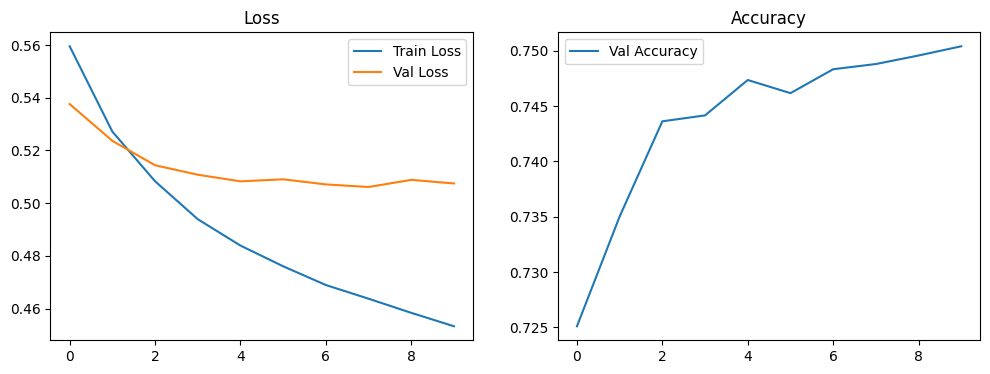

In [23]:
# Load data
print("-"*50)
print("Loading data...")
t = time()

df_train = load_data(path_to_training_tweets)
df_eval = load_data(path_to_eval_tweets)

print(f"Data loaded in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Grouping 
print("Grouping tweets...")
t = time()

df_train = concat_tweets(df_train, MAX_SUBGROUP=150)
df_eval = concat_tweets(df_eval, MAX_SUBGROUP=150, event_type=False)

print(f"Tweets grouped in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Preprocessing
print("Preprocessing...")
t = time()

df_train = preprocessing(df_train)
df_eval = preprocessing(df_eval)

print(f"Data preprocessed in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Splitting
print("Splitting data...")
t = time()

train, test = train_test_split(df_train, test_size=0.3, random_state=42)

print(f"Data splitted in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Creating the vocabulary
print("Creating the vocabulary...")
t = time()

vocab, keywords = create_vocab(train, 'Tweet', tokenizer, number_of_words_in_dict)
vocab_eval, keywords_eval = create_vocab(df_eval, 'Tweet', tokenizer, number_of_words_in_dict)

print(f'Proximity between keywords and keywords_eval: {proximity_keywords(keywords, keywords_eval)*100:.2f}%')
print(f"Vocabulary created in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Embedding
print("Embedding...")
t = time()

train_X = embedding(train['Tweet'], keywords=keywords)
test_X = embedding(test['Tweet'], keywords=keywords)
eval_X = embedding(df_eval['Tweet'], keywords=keywords)

print(f"Data embedded in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Creating the datasets
print("Creating the datasets...")
t = time()

train_loader, test_loader = create_sets(train, test, train_X, test_X)

print(f"Datasets created in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Hyperparameters
input_dim = train_X.shape[1]
hidden_dims = [64]
dropouts = [0.2]
output_dim = 1

# Model
model = NNModel(input_dim, hidden_dims, output_dim, dropouts)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training
print("Training the model...")
t = time()

history = train_model(model, train_loader, test_loader, optimizer, criterion, device)

print(f"Model trained in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Plot training history
plot_history(history)


# Improve the preprocessing 

We change the preprocessing in order to replace hastags, numbers, trigrams, countries, ... by an unique represent of these classes, we add stemming and remove punctuation and remove urls

In [24]:
# Extend the trigram list with full country names
list_of_countries_trigrams = [
    'AFG', 'RSA', 'ALB', 'ALG', 'GER', 'AND', 'ENG', 'ANG', 'AIA', 'ATG', 'KSA', 'ARG', 'ARM', 'ARU', 'AUS', 'AUT',
    'AZE', 'BAH', 'BHR', 'BAN', 'BRB', 'BEL', 'BLZ', 'BEN', 'BER', 'BHU', 'BLR', 'MYA', 'BOL', 'BIH', 'BOT', 'BRA',
    'BRU', 'BUL', 'BFA', 'BDI', 'CAM', 'CMR', 'CAN', 'CPV', 'CHI', 'CHN', 'CYP', 'COL', 'COM', 'CGO', 'PRK', 'KOR',
    'CRC', 'CIV', 'CRO', 'CUB', 'CUR', 'DEN', 'DJI', 'DMA', 'SCO', 'EGY', 'UAE', 'ECU', 'ERI', 'ESP', 'EST', 'ESW',
    'USA', 'ETH', 'FIJ', 'FIN', 'FRA', 'GAB', 'GAM', 'GEO', 'GHA', 'GIB', 'GRE', 'GRN', 'GUA', 'GUM', 'GUI', 'EQG',
    'GNB', 'GUY', 'HAI', 'HON', 'HKG', 'HUN', 'CAY', 'COK', 'FRO', 'SOL', 'TCA', 'VGB', 'VIR', 'IND', 'IDN', 'IRQ',
    'IRN', 'IRL', 'NIR', 'ISL', 'ISR', 'ITA', 'JAM', 'JPN', 'JOR', 'KAZ', 'KEN', 'KGZ', 'KVX', 'KUW', 'LAO', 'LES',
    'LVA', 'LBN', 'LBR', 'LBY', 'LIE', 'LTU', 'LUX', 'MAC', 'MKD', 'MAD', 'MAS', 'MWI', 'MDV', 'MLI', 'MLT', 'MAR',
    'MRI', 'MTN', 'MEX', 'MDA', 'MNG', 'MNE', 'MSR', 'MOZ', 'NAM', 'NEP', 'NCA', 'NIG', 'NGA', 'NOR', 'NCL', 'NZL',
    'OMA', 'UGA', 'UZB', 'PAK', 'PLE', 'PAN', 'PNG', 'PAR', 'NED', 'WAL', 'PER', 'PHI', 'POL', 'PUR', 'POR', 'QAT',
    'COD', 'CTA', 'DOM', 'CZE', 'ROU', 'RUS', 'RWA', 'SKN', 'SMR', 'VIN', 'LCA', 'SLV', 'SAM', 'ASA', 'STP', 'SEN',
    'SRB', 'SEY', 'SLE', 'SIN', 'SVK', 'SVN', 'SOM', 'SDN', 'SSD', 'SRI', 'SWE', 'SUI', 'SUR', 'SYR', 'TJK', 'TAH',
    'TPE', 'TAN', 'CHA', 'THA', 'TLS', 'TOG', 'TGA', 'TRI', 'TUN', 'TKM', 'TUR', 'UKR', 'URU', 'VAN', 'VEN', 'VIE',
    'YEM', 'ZAM', 'ZIM', 'BOE', 'GUF', 'GBR', 'GLP', 'NMI', 'KIR', 'MTQ', 'NIU', 'REU', 'SMN', 'SMA', 'TUV', 'ZAN',
    'ALA', 'COR', 'GRL', 'GUE', 'IMA', 'FLK', 'MHL', 'JER', 'MYT', 'FSM', 'MCO', 'PLW', 'EUS', 'ESH', 'BLM', 'SPM',
    'SHN', 'VAT', 'WLF'
]

# Add full country names dynamically using pycountry
list_of_countries_full_names = english_countries = ['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo', 'Congo (Democratic Republic)', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'East Timor', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Ivory Coast', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kiribati', 'Kosovo', 'Kuwait', 'Kyrgyzstan', 'Laos', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Libya', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta', 'Marshall Islands', 'Mauritania', 'Mauritius', 'Mexico', 'Federated States of Micronesia', 'Moldova', 'Monaco', 'Mongolia', 'Montenegro', 'Morocco', 'Mozambique', 'Myanmar (Burma)', 'Namibia', 'Nauru', 'Nepal', 'Netherlands', 'New Zealand', 'Nicaragua', 'Niger', 'Nigeria', 'North Korea', 'North Macedonia', 'Norway', 'Oman', 'Pakistan', 'Palau', 'Panama', 'Papua New Guinea', 'Paraguay', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Qatar', 'Romania', 'Russia', 'Rwanda', 'St Kitts and Nevis', 'St Lucia', 'St Vincent', 'Samoa', 'San Marino', 'Sao Tome and Principe', 'Saudi Arabia', 'Senegal', 'Serbia', 'Seychelles', 'Sierra Leone', 'Singapore', 'Slovakia', 'Slovenia', 'Solomon Islands', 'Somalia', 'South Africa', 'South Korea', 'South Sudan', 'Spain', 'Sri Lanka', 'Sudan', 'Suriname', 'Sweden', 'Switzerland', 'Syria', 'Tajikistan', 'Tanzania', 'Thailand', 'The Bahamas', 'The Gambia', 'Togo', 'Tonga', 'Trinidad and Tobago', 'Tunisia', 'Turkey', 'Turkmenistan', 'Tuvalu', 'Uganda', 'Ukraine', 'United Arab Emirates', 'United Kingdom', 'United States', 'Uruguay', 'Uzbekistan', 'Vanuatu', 'Vatican City', 'Venezuela', 'Vietnam', 'Yemen', 'Zambia', 'Zimbabwe']


# Combine trigrams and full names into one list
list_of_countries_trigrams.extend(list_of_countries_full_names)
list_of_countries_trigrams = list(set(list_of_countries_trigrams))  # Remove duplicates

# Preload stopwords (ensure NLTK stopwords are downloaded)
stop_words = set(stopwords.words("english"))

def preprocessing(df):
    # Compile regex patterns for efficiency
    url_pattern = re.compile(r"http[s]?://\S+|www\.\S+")
    mention_pattern = re.compile(r"@\w+")
    hashtag_pattern = re.compile(r"#\w+")
    number_pattern = re.compile(r"\d+")
    punctuation_pattern = re.compile(r"[^\w\s]")
    country_pattern = re.compile(r"\b(" + "|".join(map(re.escape, list_of_countries_trigrams)) + r")\b", re.IGNORECASE)

    def clean_tweet(tweet):
        tweet = tweet.lower()  # Lowercase the text
        tweet = url_pattern.sub("", tweet)  # Remove URLs
        tweet = mention_pattern.sub("user", tweet)  # Replace mentions with 'user'
        tweet = hashtag_pattern.sub("hashtag", tweet)  # Replace hashtags with 'hashtag'
        tweet = number_pattern.sub("number", tweet)  # Replace numbers with 'number'
        tweet = country_pattern.sub("country", tweet)  # Replace country trigrams with 'country'
        tweet = punctuation_pattern.sub("", tweet)  # Remove punctuation
        tweet = " ".join([word for word in tweet.split() if word not in stop_words])  # Remove stopwords
        return tweet

    # Apply cleaning to the "Tweet" column
    df["Tweet"] = df["Tweet"].apply(clean_tweet)
    return df

In [25]:
print(list_of_countries_trigrams)

['Ghana', 'CAM', 'SMR', 'SEN', 'Chad', 'VIR', 'SOL', 'Sierra Leone', 'Greece', 'India', 'Austria', 'PNG', 'SOM', 'Gabon', 'TUR', 'AND', 'FSM', 'NZL', 'CAN', 'ZAN', 'Vanuatu', 'PER', 'TRI', 'BDI', 'Bhutan', 'United Kingdom', 'NIU', 'Burundi', 'BUL', 'DJI', 'SYR', 'Slovakia', 'Egypt', 'CRO', 'Japan', 'MYT', 'WLF', 'Sudan', 'KVX', 'New Zealand', 'KOR', 'ECU', 'COD', 'United Arab Emirates', 'ZAM', 'Kiribati', 'Cambodia', 'PUR', 'Slovenia', 'Tunisia', 'Costa Rica', 'Qatar', 'Kuwait', 'SMA', 'MEX', 'Tuvalu', 'FLK', 'Ireland', 'ARM', 'Montenegro', 'Libya', 'VAT', 'BRB', 'Seychelles', 'Vietnam', 'ETH', 'HON', 'SHN', 'Peru', 'Indonesia', 'SEY', 'Central African Republic', 'Lithuania', 'CHA', 'Poland', 'Zambia', 'GAM', 'USA', 'LCA', 'GEO', 'CUR', 'MLI', 'COM', 'PAR', 'KIR', 'Angola', 'IMA', 'UZB', 'Jordan', 'BLM', 'Algeria', 'LES', 'SWE', 'Monaco', 'Philippines', 'CUB', 'ZIM', 'SUR', 'North Macedonia', 'Maldives', 'ITA', 'MDA', 'BAN', 'GAB', 'PRK', 'YEM', 'TLS', 'SIN', 'Lesotho', 'Malta', 'URU',

In [26]:
df_example = pd.DataFrame({"Tweet": ["Hello, I am a test", "I am a test", "I am a test #test @hihi aus btf.  🎁, Spain, Ivory Coast"]})
print(preprocessing(df_example))

                                           Tweet
0                                     hello test
1                                           test
2  test hashtag user country btf country country


--------------------------------------------------
Loading data...


Data loaded in 6.47 seconds
--------------------------------------------------

Grouping tweets...
Tweets grouped in 7.11 seconds
--------------------------------------------------

Preprocessing...
Data preprocessed in 650.09 seconds
--------------------------------------------------

Splitting data...
Data splitted in 0.11 seconds
--------------------------------------------------

Creating the vocabulary...


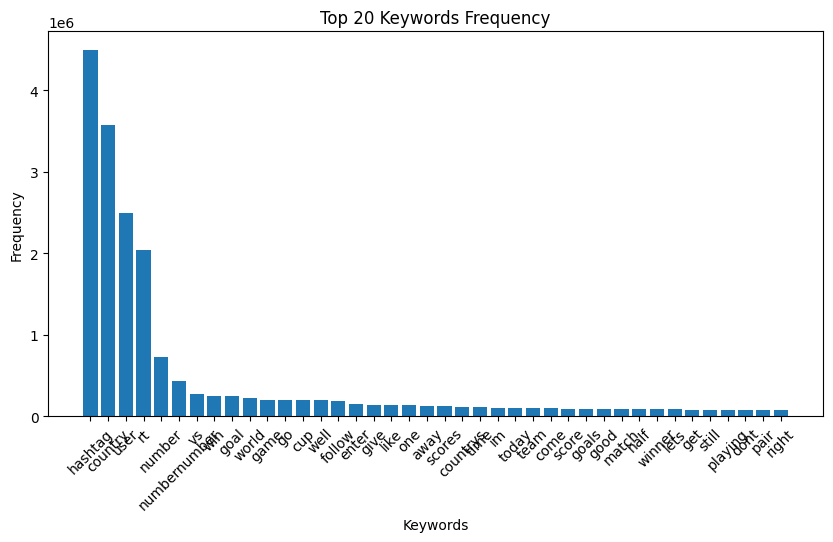

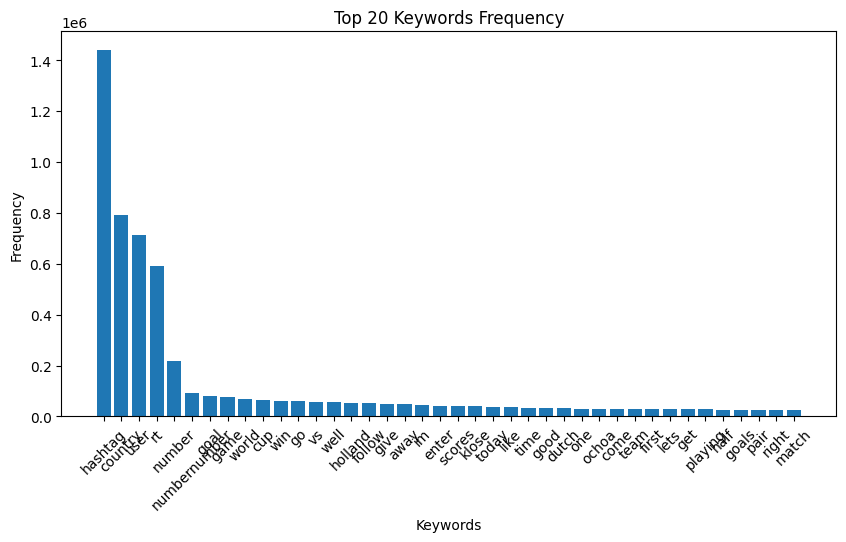

Proximity between keywords and keywords_eval: 75.20%
Vocabulary created in 17.70 seconds
--------------------------------------------------

Embedding...
Data embedded in 70.35 seconds
--------------------------------------------------

Creating the datasets...
Datasets created in 2.47 seconds
--------------------------------------------------

Training the model...
Epoch 1/10, Train Loss: 0.5757, Val Loss: 0.5603, Val Accuracy: 0.7135
Epoch 2/10, Train Loss: 0.5475, Val Loss: 0.5469, Val Accuracy: 0.7236
Epoch 3/10, Train Loss: 0.5298, Val Loss: 0.5378, Val Accuracy: 0.7286
Epoch 4/10, Train Loss: 0.5154, Val Loss: 0.5356, Val Accuracy: 0.7330
Epoch 5/10, Train Loss: 0.5040, Val Loss: 0.5322, Val Accuracy: 0.7321
Epoch 6/10, Train Loss: 0.4946, Val Loss: 0.5304, Val Accuracy: 0.7341
Epoch 7/10, Train Loss: 0.4881, Val Loss: 0.5283, Val Accuracy: 0.7379
Epoch 8/10, Train Loss: 0.4830, Val Loss: 0.5285, Val Accuracy: 0.7349
Epoch 9/10, Train Loss: 0.4795, Val Loss: 0.5321, Val Accuracy:

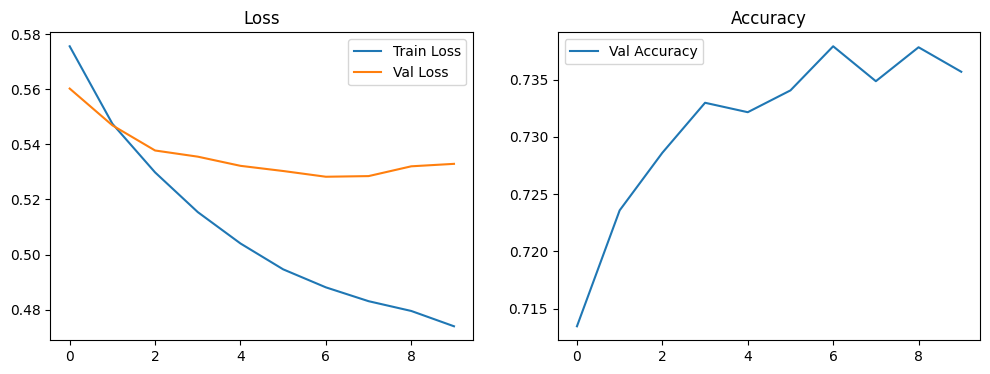

In [27]:
# Load data
print("-"*50)
print("Loading data...")
t = time()

df_train = load_data(path_to_training_tweets)
df_eval = load_data(path_to_eval_tweets)

print(f"Data loaded in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Grouping 
print("Grouping tweets...")
t = time()

df_train = concat_tweets(df_train, MAX_SUBGROUP=150)
df_eval = concat_tweets(df_eval, MAX_SUBGROUP=150, event_type=False)

print(f"Tweets grouped in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Preprocessing
print("Preprocessing...")
t = time()

df_train = preprocessing(df_train)
df_eval = preprocessing(df_eval)

print(f"Data preprocessed in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Splitting
print("Splitting data...")
t = time()

train, test = train_test_split(df_train, test_size=0.3, random_state=42)

print(f"Data splitted in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Creating the vocabulary
print("Creating the vocabulary...")
t = time()

vocab, keywords = create_vocab(train, 'Tweet', tokenizer, number_of_words_in_dict)
vocab_eval, keywords_eval = create_vocab(df_eval, 'Tweet', tokenizer, number_of_words_in_dict)

plot_frequency(vocab, keywords)
plot_frequency(vocab_eval, keywords_eval)

print(f'Proximity between keywords and keywords_eval: {proximity_keywords(keywords, keywords_eval)*100:.2f}%')
print(f"Vocabulary created in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Embedding
print("Embedding...")
t = time()

train_X = embedding(train['Tweet'], keywords=keywords)
test_X = embedding(test['Tweet'], keywords=keywords)
eval_X = embedding(df_eval['Tweet'], keywords=keywords)

print(f"Data embedded in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Creating the datasets
print("Creating the datasets...")
t = time()

train_loader, test_loader = create_sets(train, test, train_X, test_X)

print(f"Datasets created in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Hyperparameters
input_dim = train_X.shape[1]
hidden_dims = [64]
dropouts = [0.2]
output_dim = 1

# Model
model = NNModel(input_dim, hidden_dims, output_dim, dropouts)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training
print("Training the model...")
t = time()

history = train_model(model, train_loader, test_loader, optimizer, criterion, device)

print(f"Model trained in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Plot training history
plot_history(history)


#### Removing countries/trigrams/#/@/urls...

In [28]:
# Extend the trigram list with full country names
list_of_countries_trigrams = [
    'AFG', 'RSA', 'ALB', 'ALG', 'GER', 'AND', 'ENG', 'ANG', 'AIA', 'ATG', 'KSA', 'ARG', 'ARM', 'ARU', 'AUS', 'AUT',
    'AZE', 'BAH', 'BHR', 'BAN', 'BRB', 'BEL', 'BLZ', 'BEN', 'BER', 'BHU', 'BLR', 'MYA', 'BOL', 'BIH', 'BOT', 'BRA',
    'BRU', 'BUL', 'BFA', 'BDI', 'CAM', 'CMR', 'CAN', 'CPV', 'CHI', 'CHN', 'CYP', 'COL', 'COM', 'CGO', 'PRK', 'KOR',
    'CRC', 'CIV', 'CRO', 'CUB', 'CUR', 'DEN', 'DJI', 'DMA', 'SCO', 'EGY', 'UAE', 'ECU', 'ERI', 'ESP', 'EST', 'ESW',
    'USA', 'ETH', 'FIJ', 'FIN', 'FRA', 'GAB', 'GAM', 'GEO', 'GHA', 'GIB', 'GRE', 'GRN', 'GUA', 'GUM', 'GUI', 'EQG',
    'GNB', 'GUY', 'HAI', 'HON', 'HKG', 'HUN', 'CAY', 'COK', 'FRO', 'SOL', 'TCA', 'VGB', 'VIR', 'IND', 'IDN', 'IRQ',
    'IRN', 'IRL', 'NIR', 'ISL', 'ISR', 'ITA', 'JAM', 'JPN', 'JOR', 'KAZ', 'KEN', 'KGZ', 'KVX', 'KUW', 'LAO', 'LES',
    'LVA', 'LBN', 'LBR', 'LBY', 'LIE', 'LTU', 'LUX', 'MAC', 'MKD', 'MAD', 'MAS', 'MWI', 'MDV', 'MLI', 'MLT', 'MAR',
    'MRI', 'MTN', 'MEX', 'MDA', 'MNG', 'MNE', 'MSR', 'MOZ', 'NAM', 'NEP', 'NCA', 'NIG', 'NGA', 'NOR', 'NCL', 'NZL',
    'OMA', 'UGA', 'UZB', 'PAK', 'PLE', 'PAN', 'PNG', 'PAR', 'NED', 'WAL', 'PER', 'PHI', 'POL', 'PUR', 'POR', 'QAT',
    'COD', 'CTA', 'DOM', 'CZE', 'ROU', 'RUS', 'RWA', 'SKN', 'SMR', 'VIN', 'LCA', 'SLV', 'SAM', 'ASA', 'STP', 'SEN',
    'SRB', 'SEY', 'SLE', 'SIN', 'SVK', 'SVN', 'SOM', 'SDN', 'SSD', 'SRI', 'SWE', 'SUI', 'SUR', 'SYR', 'TJK', 'TAH',
    'TPE', 'TAN', 'CHA', 'THA', 'TLS', 'TOG', 'TGA', 'TRI', 'TUN', 'TKM', 'TUR', 'UKR', 'URU', 'VAN', 'VEN', 'VIE',
    'YEM', 'ZAM', 'ZIM', 'BOE', 'GUF', 'GBR', 'GLP', 'NMI', 'KIR', 'MTQ', 'NIU', 'REU', 'SMN', 'SMA', 'TUV', 'ZAN',
    'ALA', 'COR', 'GRL', 'GUE', 'IMA', 'FLK', 'MHL', 'JER', 'MYT', 'FSM', 'MCO', 'PLW', 'EUS', 'ESH', 'BLM', 'SPM',
    'SHN', 'VAT', 'WLF'
]

# Add full country names dynamically using pycountry
list_of_countries_full_names = english_countries = ['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo', 'Congo (Democratic Republic)', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'East Timor', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Ivory Coast', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kiribati', 'Kosovo', 'Kuwait', 'Kyrgyzstan', 'Laos', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Libya', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta', 'Marshall Islands', 'Mauritania', 'Mauritius', 'Mexico', 'Federated States of Micronesia', 'Moldova', 'Monaco', 'Mongolia', 'Montenegro', 'Morocco', 'Mozambique', 'Myanmar (Burma)', 'Namibia', 'Nauru', 'Nepal', 'Netherlands', 'New Zealand', 'Nicaragua', 'Niger', 'Nigeria', 'North Korea', 'North Macedonia', 'Norway', 'Oman', 'Pakistan', 'Palau', 'Panama', 'Papua New Guinea', 'Paraguay', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Qatar', 'Romania', 'Russia', 'Rwanda', 'St Kitts and Nevis', 'St Lucia', 'St Vincent', 'Samoa', 'San Marino', 'Sao Tome and Principe', 'Saudi Arabia', 'Senegal', 'Serbia', 'Seychelles', 'Sierra Leone', 'Singapore', 'Slovakia', 'Slovenia', 'Solomon Islands', 'Somalia', 'South Africa', 'South Korea', 'South Sudan', 'Spain', 'Sri Lanka', 'Sudan', 'Suriname', 'Sweden', 'Switzerland', 'Syria', 'Tajikistan', 'Tanzania', 'Thailand', 'The Bahamas', 'The Gambia', 'Togo', 'Tonga', 'Trinidad and Tobago', 'Tunisia', 'Turkey', 'Turkmenistan', 'Tuvalu', 'Uganda', 'Ukraine', 'United Arab Emirates', 'United Kingdom', 'United States', 'Uruguay', 'Uzbekistan', 'Vanuatu', 'Vatican City', 'Venezuela', 'Vietnam', 'Yemen', 'Zambia', 'Zimbabwe']


# Combine trigrams and full names into one list
list_of_countries_trigrams.extend(list_of_countries_full_names)
list_of_countries_trigrams = list(set(list_of_countries_trigrams))  # Remove duplicates

# Preload stopwords (ensure NLTK stopwords are downloaded)
stop_words = set(stopwords.words("english"))

def preprocessing(df):
    # Compile regex patterns for efficiency
    url_pattern = re.compile(r"http[s]?://\S+|www\.\S+")
    mention_pattern = re.compile(r"@\w+")
    hashtag_pattern = re.compile(r"#\w+")
    number_pattern = re.compile(r"\d+")
    punctuation_pattern = re.compile(r"[^\w\s]")
    country_pattern = re.compile(r"\b(" + "|".join(map(re.escape, list_of_countries_trigrams)) + r")\b", re.IGNORECASE)
    rt_pattern = re.compile(r"rt")

    def clean_tweet(tweet):
        tweet = tweet.lower()  # Lowercase the text
        tweet = url_pattern.sub("", tweet)  # Remove URLs
        tweet = rt_pattern.sub("", tweet)  # Remove RT
        tweet = mention_pattern.sub("", tweet)  # Replace mentions with 'user'
        tweet = hashtag_pattern.sub("", tweet)  # Replace hashtags with 'hashtag'
        tweet = number_pattern.sub("", tweet)  # Replace numbers with 'number'
        tweet = country_pattern.sub("", tweet)  # Replace country trigrams with 'country'
        tweet = punctuation_pattern.sub("", tweet)  # Remove punctuation
        tweet = " ".join([word for word in tweet.split() if word not in stop_words])  # Remove stopwords
        return tweet

    # Apply cleaning to the "Tweet" column
    df["Tweet"] = df["Tweet"].apply(clean_tweet)
    return df

--------------------------------------------------


Loading data...
Data loaded in 6.55 seconds
--------------------------------------------------

Grouping tweets...
Tweets grouped in 7.16 seconds
--------------------------------------------------

Preprocessing...
Data preprocessed in 512.46 seconds
--------------------------------------------------

Splitting data...
Data splitted in 0.09 seconds
--------------------------------------------------

Creating the vocabulary...


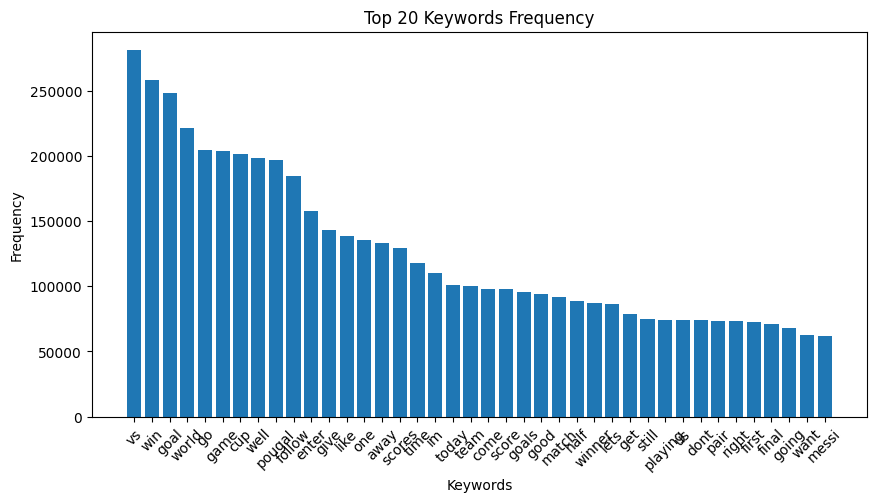

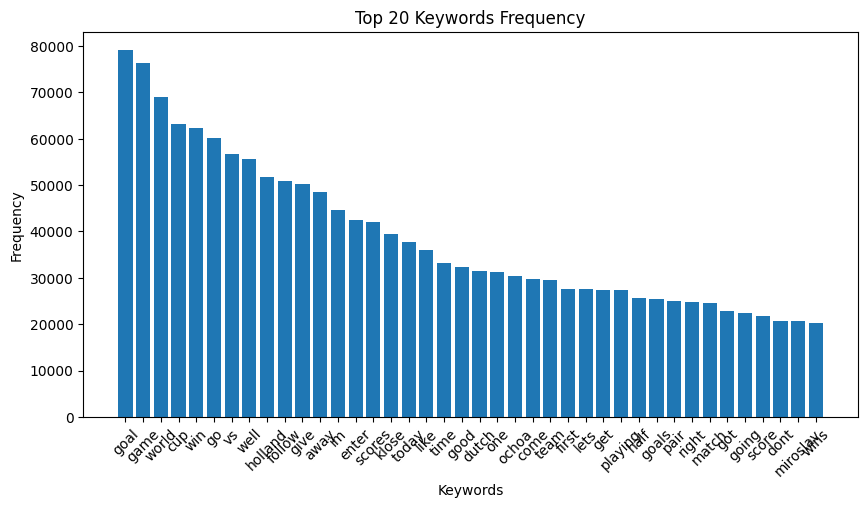

Proximity between keywords and keywords_eval: 75.30%
Vocabulary created in 10.99 seconds
--------------------------------------------------

Embedding...
Data embedded in 64.40 seconds
--------------------------------------------------

Creating the datasets...
Datasets created in 2.43 seconds
--------------------------------------------------

Training the model...
Epoch 1/10, Train Loss: 0.5798, Val Loss: 0.5634, Val Accuracy: 0.7101
Epoch 2/10, Train Loss: 0.5519, Val Loss: 0.5498, Val Accuracy: 0.7202
Epoch 3/10, Train Loss: 0.5348, Val Loss: 0.5410, Val Accuracy: 0.7268
Epoch 4/10, Train Loss: 0.5191, Val Loss: 0.5359, Val Accuracy: 0.7308
Epoch 5/10, Train Loss: 0.5100, Val Loss: 0.5326, Val Accuracy: 0.7311
Epoch 6/10, Train Loss: 0.5012, Val Loss: 0.5325, Val Accuracy: 0.7323
Epoch 7/10, Train Loss: 0.4944, Val Loss: 0.5321, Val Accuracy: 0.7338
Epoch 8/10, Train Loss: 0.4891, Val Loss: 0.5306, Val Accuracy: 0.7335
Epoch 9/10, Train Loss: 0.4839, Val Loss: 0.5306, Val Accuracy:

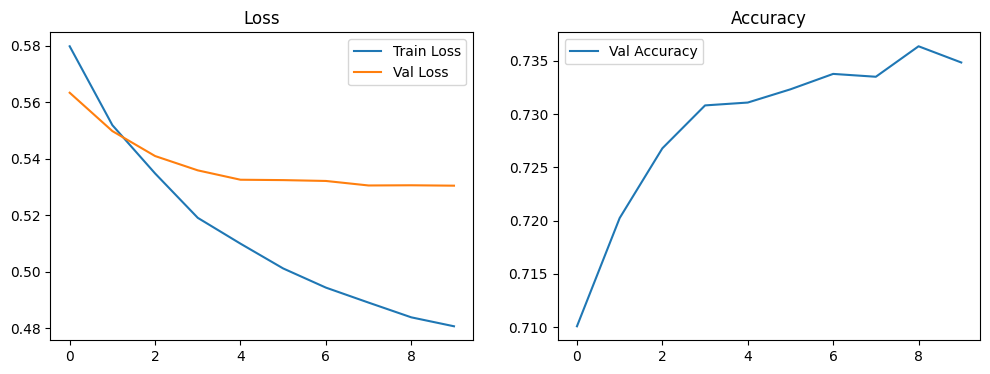

In [29]:
# Load data
print("-"*50)
print("Loading data...")
t = time()

df_train = load_data(path_to_training_tweets)
df_eval = load_data(path_to_eval_tweets)

print(f"Data loaded in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Grouping 
print("Grouping tweets...")
t = time()

df_train = concat_tweets(df_train, MAX_SUBGROUP=150)
df_eval = concat_tweets(df_eval, MAX_SUBGROUP=150, event_type=False)

print(f"Tweets grouped in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Preprocessing
print("Preprocessing...")
t = time()

df_train = preprocessing(df_train)
df_eval = preprocessing(df_eval)

print(f"Data preprocessed in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Splitting
print("Splitting data...")
t = time()

train, test = train_test_split(df_train, test_size=0.3, random_state=42)

print(f"Data splitted in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Creating the vocabulary
print("Creating the vocabulary...")
t = time()

vocab, keywords = create_vocab(train, 'Tweet', tokenizer, number_of_words_in_dict)
vocab_eval, keywords_eval = create_vocab(df_eval, 'Tweet', tokenizer, number_of_words_in_dict)

plot_frequency(vocab, keywords)
plot_frequency(vocab_eval, keywords_eval)

print(f'Proximity between keywords and keywords_eval: {proximity_keywords(keywords, keywords_eval)*100:.2f}%')
print(f"Vocabulary created in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Embedding
print("Embedding...")
t = time()

train_X = embedding(train['Tweet'], keywords=keywords)
test_X = embedding(test['Tweet'], keywords=keywords)
eval_X = embedding(df_eval['Tweet'], keywords=keywords)

print(f"Data embedded in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Creating the datasets
print("Creating the datasets...")
t = time()

train_loader, test_loader = create_sets(train, test, train_X, test_X)

print(f"Datasets created in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Hyperparameters
input_dim = train_X.shape[1]
hidden_dims = [64]
dropouts = [0.2]
output_dim = 1

# Model
model = NNModel(input_dim, hidden_dims, output_dim, dropouts)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training
print("Training the model...")
t = time()

history = train_model(model, train_loader, test_loader, optimizer, criterion, device)

print(f"Model trained in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Plot training history
plot_history(history)


#### Taking the vocabulary on the concat of eval+train

Using the above done prepocessing because it is slow

Splitting data...
Data splitted in 0.05 seconds
--------------------------------------------------

Creating the vocabulary...


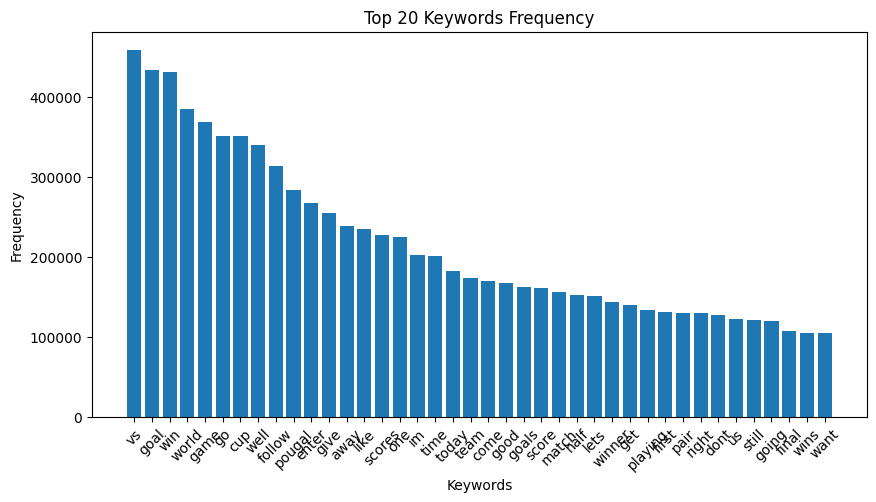

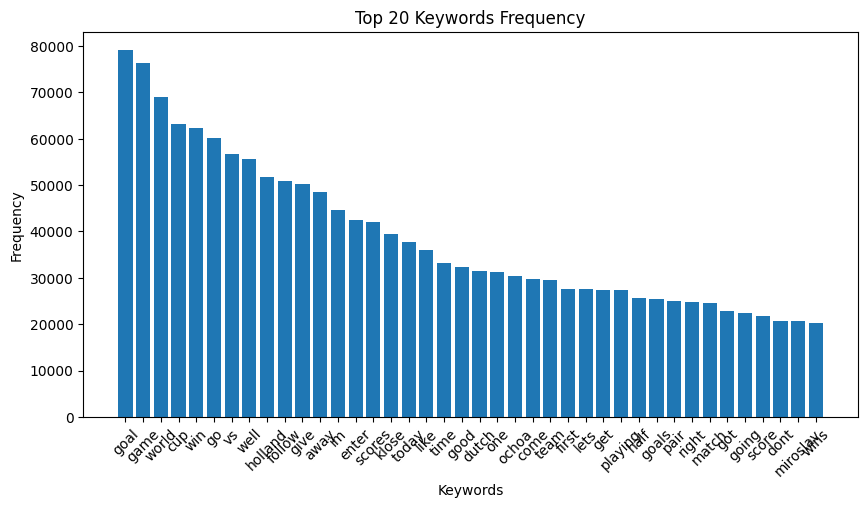

Proximity between keywords and keywords_eval: 80.50%
Vocabulary created in 16.94 seconds
--------------------------------------------------

Embedding...
Data embedded in 62.93 seconds
--------------------------------------------------

Creating the datasets...
Datasets created in 2.47 seconds
--------------------------------------------------

Training the model...
Epoch 1/10, Train Loss: 0.5816, Val Loss: 0.5667, Val Accuracy: 0.7082
Epoch 2/10, Train Loss: 0.5549, Val Loss: 0.5526, Val Accuracy: 0.7202
Epoch 3/10, Train Loss: 0.5366, Val Loss: 0.5422, Val Accuracy: 0.7261
Epoch 4/10, Train Loss: 0.5226, Val Loss: 0.5375, Val Accuracy: 0.7297
Epoch 5/10, Train Loss: 0.5113, Val Loss: 0.5356, Val Accuracy: 0.7294
Epoch 6/10, Train Loss: 0.5024, Val Loss: 0.5350, Val Accuracy: 0.7289
Epoch 7/10, Train Loss: 0.4959, Val Loss: 0.5353, Val Accuracy: 0.7315
Epoch 8/10, Train Loss: 0.4894, Val Loss: 0.5360, Val Accuracy: 0.7331
Epoch 9/10, Train Loss: 0.4844, Val Loss: 0.5344, Val Accuracy:

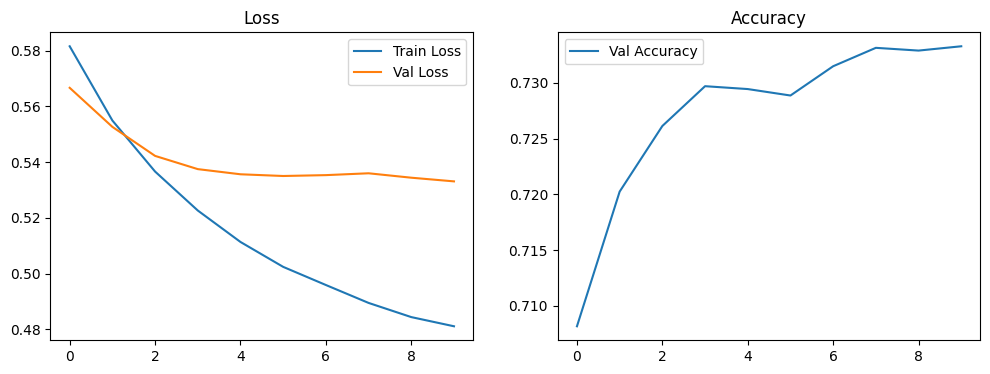

In [30]:
# Splitting
print("Splitting data...")
t = time()

train, test = train_test_split(df_train, test_size=0.3, random_state=42)

print(f"Data splitted in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Creating the vocabulary
print("Creating the vocabulary...")
t = time()

vocab, keywords = create_vocab(pd.concat([train, test, df_eval]), 'Tweet', tokenizer, number_of_words_in_dict)
vocab_eval, keywords_eval = create_vocab(df_eval, 'Tweet', tokenizer, number_of_words_in_dict)

plot_frequency(vocab, keywords)
plot_frequency(vocab_eval, keywords_eval)

print(f'Proximity between keywords and keywords_eval: {proximity_keywords(keywords, keywords_eval)*100:.2f}%')
print(f"Vocabulary created in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Embedding
print("Embedding...")
t = time()

train_X = embedding(train['Tweet'], keywords=keywords)
test_X = embedding(test['Tweet'], keywords=keywords)
eval_X = embedding(df_eval['Tweet'], keywords=keywords)

print(f"Data embedded in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Creating the datasets
print("Creating the datasets...")
t = time()

train_loader, test_loader = create_sets(train, test, train_X, test_X)

print(f"Datasets created in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Hyperparameters
input_dim = train_X.shape[1]
hidden_dims = [64]
dropouts = [0.2]
output_dim = 1

# Model
model = NNModel(input_dim, hidden_dims, output_dim, dropouts)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training
print("Training the model...")
t = time()

history = train_model(model, train_loader, test_loader, optimizer, criterion, device)

print(f"Model trained in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Plot training history
plot_history(history)


idem with a bigger dictionary

Splitting data...
Data splitted in 0.05 seconds
--------------------------------------------------

Creating the vocabulary...


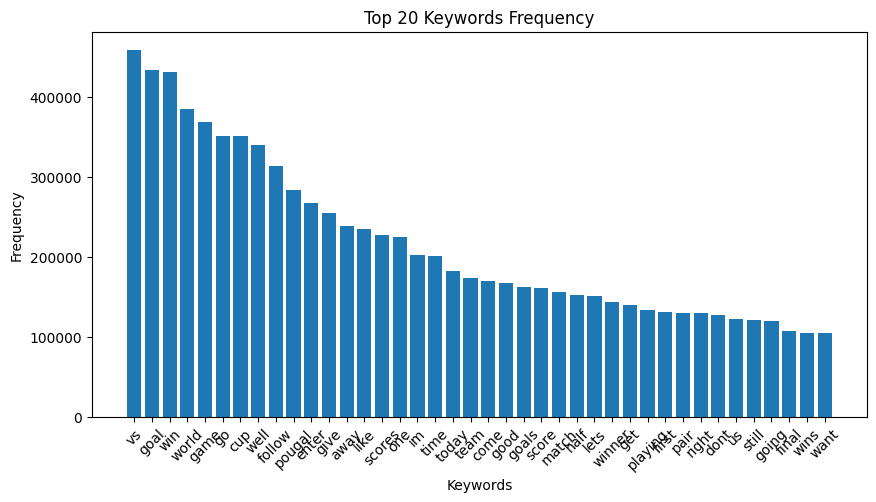

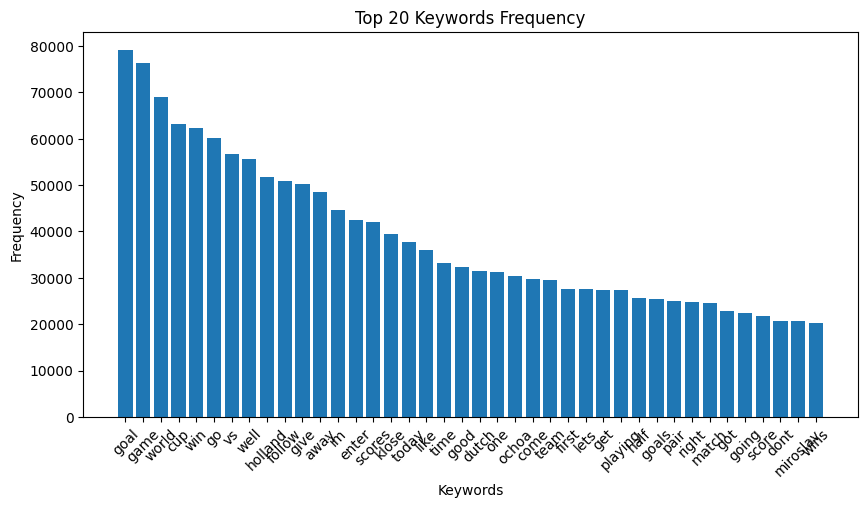

Proximity between keywords and keywords_eval: 79.80%
Vocabulary created in 17.03 seconds
--------------------------------------------------

Embedding...
Data embedded in 164.03 seconds
--------------------------------------------------

Creating the datasets...
Datasets created in 7.77 seconds
--------------------------------------------------

Training the model...
Epoch 1/10, Train Loss: 0.5683, Val Loss: 0.5507, Val Accuracy: 0.7197
Epoch 2/10, Train Loss: 0.5346, Val Loss: 0.5414, Val Accuracy: 0.7268
Epoch 3/10, Train Loss: 0.5142, Val Loss: 0.5359, Val Accuracy: 0.7304
Epoch 4/10, Train Loss: 0.4923, Val Loss: 0.5307, Val Accuracy: 0.7372
Epoch 5/10, Train Loss: 0.4713, Val Loss: 0.5307, Val Accuracy: 0.7403
Epoch 6/10, Train Loss: 0.4522, Val Loss: 0.5350, Val Accuracy: 0.7393
Epoch 7/10, Train Loss: 0.4366, Val Loss: 0.5369, Val Accuracy: 0.7396
Epoch 8/10, Train Loss: 0.4235, Val Loss: 0.5411, Val Accuracy: 0.7406
Epoch 9/10, Train Loss: 0.4121, Val Loss: 0.5443, Val Accuracy

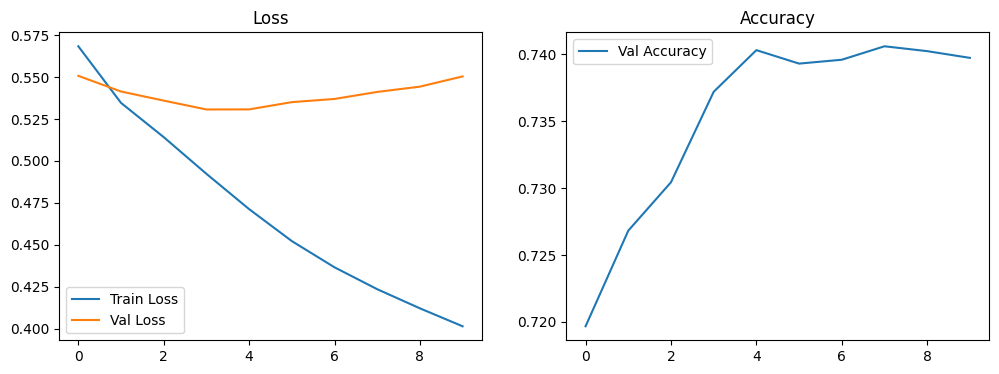

In [31]:
number_of_words_in_dict = 3000

# Splitting
print("Splitting data...")
t = time()

train, test = train_test_split(df_train, test_size=0.3, random_state=42)

print(f"Data splitted in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Creating the vocabulary
print("Creating the vocabulary...")
t = time()

vocab, keywords = create_vocab(pd.concat([train, test, df_eval]), 'Tweet', tokenizer, number_of_words_in_dict)
vocab_eval, keywords_eval = create_vocab(df_eval, 'Tweet', tokenizer, number_of_words_in_dict)

plot_frequency(vocab, keywords)
plot_frequency(vocab_eval, keywords_eval)

print(f'Proximity between keywords and keywords_eval: {proximity_keywords(keywords, keywords_eval)*100:.2f}%')
print(f"Vocabulary created in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Embedding
print("Embedding...")
t = time()

train_X = embedding(train['Tweet'], keywords=keywords)
test_X = embedding(test['Tweet'], keywords=keywords)
eval_X = embedding(df_eval['Tweet'], keywords=keywords)

print(f"Data embedded in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Creating the datasets
print("Creating the datasets...")
t = time()

train_loader, test_loader = create_sets(train, test, train_X, test_X)

print(f"Datasets created in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Hyperparameters
input_dim = train_X.shape[1]
hidden_dims = [64]
dropouts = [0.2]
output_dim = 1

# Model
model = NNModel(input_dim, hidden_dims, output_dim, dropouts)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training
print("Training the model...")
t = time()

history = train_model(model, train_loader, test_loader, optimizer, criterion, device)

print(f"Model trained in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Plot training history
plot_history(history)


Idem with 200 words 

Splitting data...
Data splitted in 0.05 seconds
--------------------------------------------------

Creating the vocabulary...


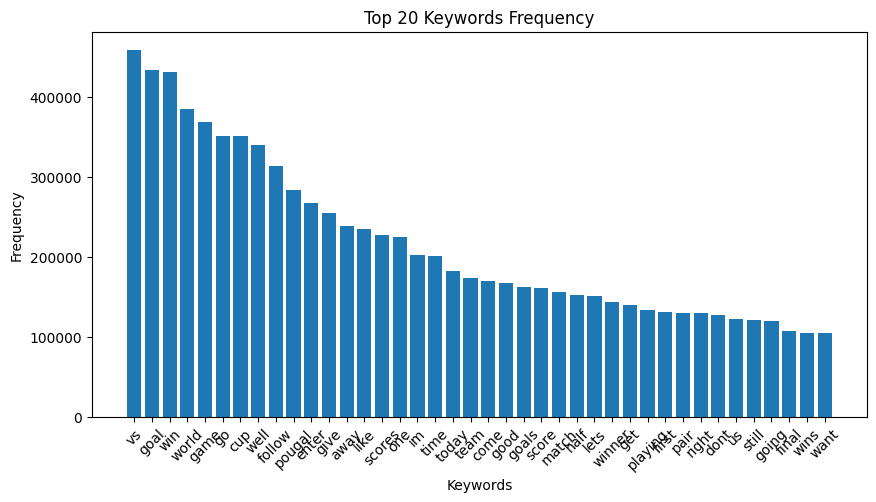

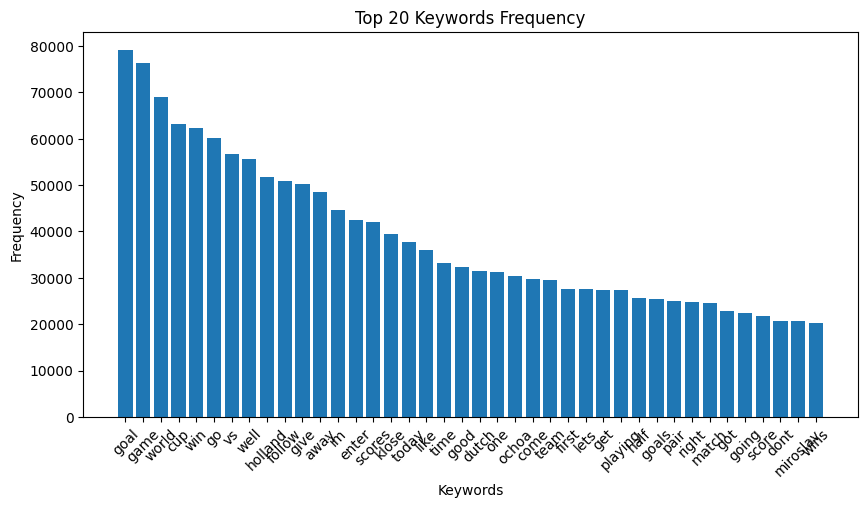

Proximity between keywords and keywords_eval: 81.00%
Vocabulary created in 16.54 seconds
--------------------------------------------------

Embedding...
Data embedded in 23.53 seconds
--------------------------------------------------

Creating the datasets...
Datasets created in 0.58 seconds
--------------------------------------------------

Training the model...
Epoch 1/10, Train Loss: 0.6117, Val Loss: 0.5968, Val Accuracy: 0.6787
Epoch 2/10, Train Loss: 0.5933, Val Loss: 0.5882, Val Accuracy: 0.6859
Epoch 3/10, Train Loss: 0.5847, Val Loss: 0.5820, Val Accuracy: 0.6915
Epoch 4/10, Train Loss: 0.5804, Val Loss: 0.5783, Val Accuracy: 0.6946
Epoch 5/10, Train Loss: 0.5771, Val Loss: 0.5783, Val Accuracy: 0.6920
Epoch 6/10, Train Loss: 0.5744, Val Loss: 0.5766, Val Accuracy: 0.6955
Epoch 7/10, Train Loss: 0.5727, Val Loss: 0.5741, Val Accuracy: 0.6962
Epoch 8/10, Train Loss: 0.5705, Val Loss: 0.5742, Val Accuracy: 0.6973
Epoch 9/10, Train Loss: 0.5706, Val Loss: 0.5738, Val Accuracy:

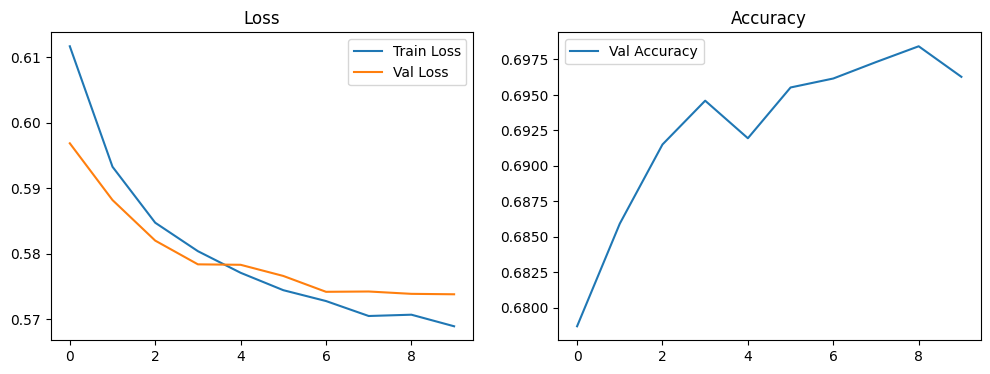

In [32]:
number_of_words_in_dict = 200

# Splitting
print("Splitting data...")
t = time()

train, test = train_test_split(df_train, test_size=0.3, random_state=42)

print(f"Data splitted in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Creating the vocabulary
print("Creating the vocabulary...")
t = time()

vocab, keywords = create_vocab(pd.concat([train, test, df_eval]), 'Tweet', tokenizer, number_of_words_in_dict)
vocab_eval, keywords_eval = create_vocab(df_eval, 'Tweet', tokenizer, number_of_words_in_dict)

plot_frequency(vocab, keywords)
plot_frequency(vocab_eval, keywords_eval)

print(f'Proximity between keywords and keywords_eval: {proximity_keywords(keywords, keywords_eval)*100:.2f}%')
print(f"Vocabulary created in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Embedding
print("Embedding...")
t = time()

train_X = embedding(train['Tweet'], keywords=keywords)
test_X = embedding(test['Tweet'], keywords=keywords)
eval_X = embedding(df_eval['Tweet'], keywords=keywords)

print(f"Data embedded in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Creating the datasets
print("Creating the datasets...")
t = time()

train_loader, test_loader = create_sets(train, test, train_X, test_X)

print(f"Datasets created in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Hyperparameters
input_dim = train_X.shape[1]
hidden_dims = [64]
dropouts = [0.2]
output_dim = 1

# Model
model = NNModel(input_dim, hidden_dims, output_dim, dropouts)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training
print("Training the model...")
t = time()

history = train_model(model, train_loader, test_loader, optimizer, criterion, device)

print(f"Model trained in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Plot training history
plot_history(history)


Idem with 500 words

Splitting data...
Data splitted in 0.05 seconds
--------------------------------------------------

Creating the vocabulary...


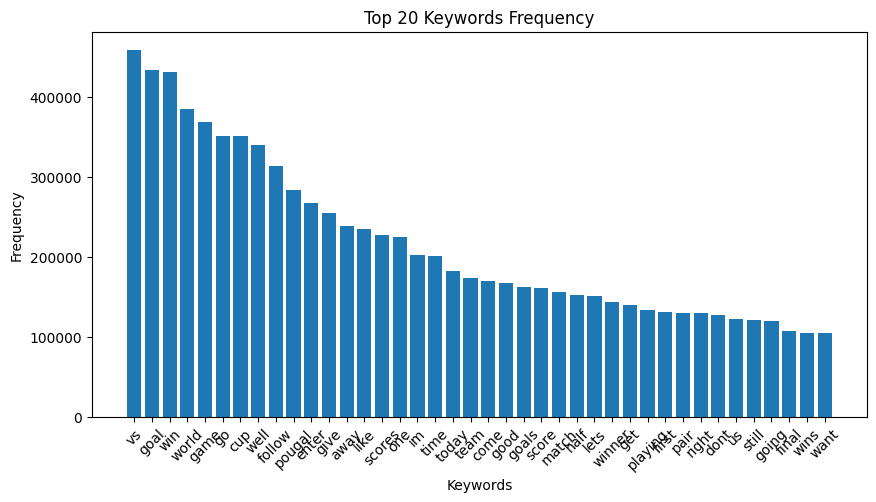

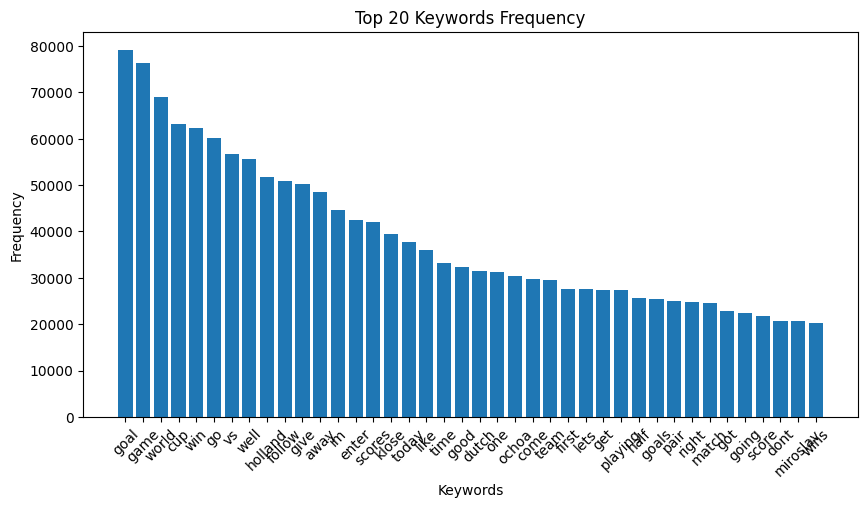

Proximity between keywords and keywords_eval: 79.60%
Vocabulary created in 16.78 seconds
--------------------------------------------------

Embedding...
Data embedded in 39.18 seconds
--------------------------------------------------

Creating the datasets...
Datasets created in 1.25 seconds
--------------------------------------------------

Training the model...
Epoch 1/10, Train Loss: 0.5923, Val Loss: 0.5755, Val Accuracy: 0.7001
Epoch 2/10, Train Loss: 0.5670, Val Loss: 0.5618, Val Accuracy: 0.7086
Epoch 3/10, Train Loss: 0.5543, Val Loss: 0.5555, Val Accuracy: 0.7134
Epoch 4/10, Train Loss: 0.5451, Val Loss: 0.5515, Val Accuracy: 0.7160
Epoch 5/10, Train Loss: 0.5385, Val Loss: 0.5505, Val Accuracy: 0.7164
Epoch 6/10, Train Loss: 0.5340, Val Loss: 0.5476, Val Accuracy: 0.7199
Epoch 7/10, Train Loss: 0.5299, Val Loss: 0.5465, Val Accuracy: 0.7204
Epoch 8/10, Train Loss: 0.5265, Val Loss: 0.5449, Val Accuracy: 0.7217
Epoch 9/10, Train Loss: 0.5246, Val Loss: 0.5454, Val Accuracy:

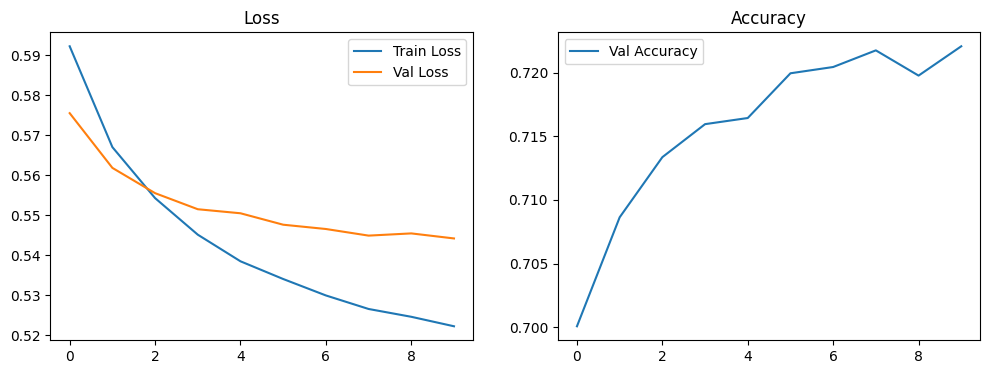

In [33]:
number_of_words_in_dict = 500

# Splitting
print("Splitting data...")
t = time()

train, test = train_test_split(df_train, test_size=0.3, random_state=42)

print(f"Data splitted in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Creating the vocabulary
print("Creating the vocabulary...")
t = time()

vocab, keywords = create_vocab(pd.concat([train, test, df_eval]), 'Tweet', tokenizer, number_of_words_in_dict)
vocab_eval, keywords_eval = create_vocab(df_eval, 'Tweet', tokenizer, number_of_words_in_dict)

plot_frequency(vocab, keywords)
plot_frequency(vocab_eval, keywords_eval)

print(f'Proximity between keywords and keywords_eval: {proximity_keywords(keywords, keywords_eval)*100:.2f}%')
print(f"Vocabulary created in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Embedding
print("Embedding...")
t = time()

train_X = embedding(train['Tweet'], keywords=keywords)
test_X = embedding(test['Tweet'], keywords=keywords)
eval_X = embedding(df_eval['Tweet'], keywords=keywords)

print(f"Data embedded in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Creating the datasets
print("Creating the datasets...")
t = time()

train_loader, test_loader = create_sets(train, test, train_X, test_X)

print(f"Datasets created in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Hyperparameters
input_dim = train_X.shape[1]
hidden_dims = [64]
dropouts = [0.2]
output_dim = 1

# Model
model = NNModel(input_dim, hidden_dims, output_dim, dropouts)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training
print("Training the model...")
t = time()

history = train_model(model, train_loader, test_loader, optimizer, criterion, device)

print(f"Model trained in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Plot training history
plot_history(history)


# idem with more layers / epochs

Splitting data...
Data splitted in 0.05 seconds
--------------------------------------------------

Creating the vocabulary...


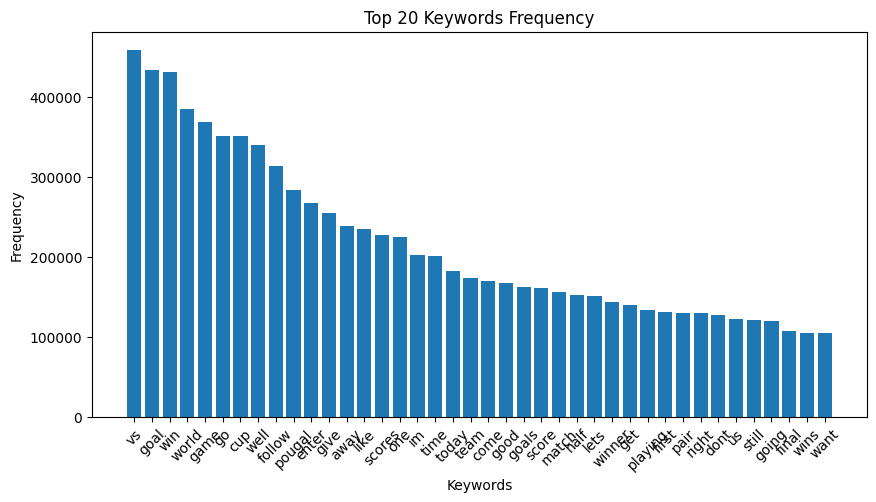

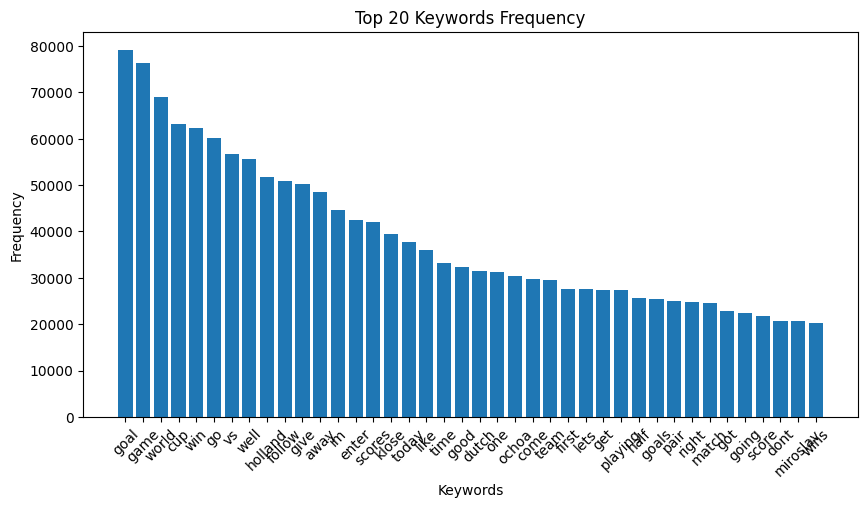

Proximity between keywords and keywords_eval: 79.60%
Vocabulary created in 16.52 seconds
--------------------------------------------------

Embedding...
Data embedded in 38.88 seconds
--------------------------------------------------

Creating the datasets...
Datasets created in 1.22 seconds
--------------------------------------------------

Training the model...
Epoch 1/10, Train Loss: 0.5903, Val Loss: 0.5573, Val Accuracy: 0.7021
Epoch 2/10, Train Loss: 0.5606, Val Loss: 0.5435, Val Accuracy: 0.7132
Epoch 3/10, Train Loss: 0.5477, Val Loss: 0.5362, Val Accuracy: 0.7178
Epoch 4/10, Train Loss: 0.5399, Val Loss: 0.5354, Val Accuracy: 0.7220
Epoch 5/10, Train Loss: 0.5335, Val Loss: 0.5302, Val Accuracy: 0.7225
Epoch 6/10, Train Loss: 0.5284, Val Loss: 0.5272, Val Accuracy: 0.7232
Epoch 7/10, Train Loss: 0.5249, Val Loss: 0.5265, Val Accuracy: 0.7242
Epoch 8/10, Train Loss: 0.5215, Val Loss: 0.5227, Val Accuracy: 0.7269
Epoch 9/10, Train Loss: 0.5188, Val Loss: 0.5237, Val Accuracy:

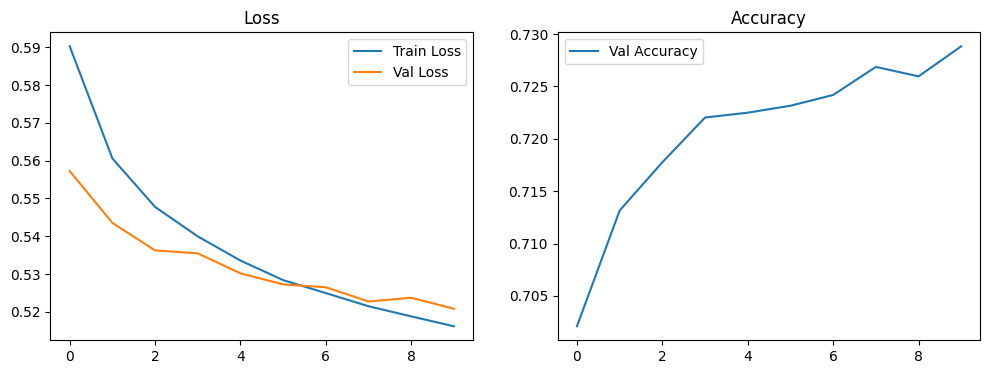

In [34]:
number_of_words_in_dict = 500

# Splitting
print("Splitting data...")
t = time()

train, test = train_test_split(df_train, test_size=0.3, random_state=42)

print(f"Data splitted in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Creating the vocabulary
print("Creating the vocabulary...")
t = time()

vocab, keywords = create_vocab(pd.concat([train, test, df_eval]), 'Tweet', tokenizer, number_of_words_in_dict)
vocab_eval, keywords_eval = create_vocab(df_eval, 'Tweet', tokenizer, number_of_words_in_dict)

plot_frequency(vocab, keywords)
plot_frequency(vocab_eval, keywords_eval)

print(f'Proximity between keywords and keywords_eval: {proximity_keywords(keywords, keywords_eval)*100:.2f}%')
print(f"Vocabulary created in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Embedding
print("Embedding...")
t = time()

train_X = embedding(train['Tweet'], keywords=keywords)
test_X = embedding(test['Tweet'], keywords=keywords)
eval_X = embedding(df_eval['Tweet'], keywords=keywords)

print(f"Data embedded in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Creating the datasets
print("Creating the datasets...")
t = time()

train_loader, test_loader = create_sets(train, test, train_X, test_X)

print(f"Datasets created in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Hyperparameters
input_dim = train_X.shape[1]
hidden_dims = [64, 32]
dropouts = [0.3, 0.3]
output_dim = 1

# Model
model = NNModel(input_dim, hidden_dims, output_dim, dropouts)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training
print("Training the model...")
t = time()

history = train_model(model, train_loader, test_loader, optimizer, criterion, device)

print(f"Model trained in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Plot training history
plot_history(history)


Splitting data...
Data splitted in 0.06 seconds
--------------------------------------------------

Creating the vocabulary...


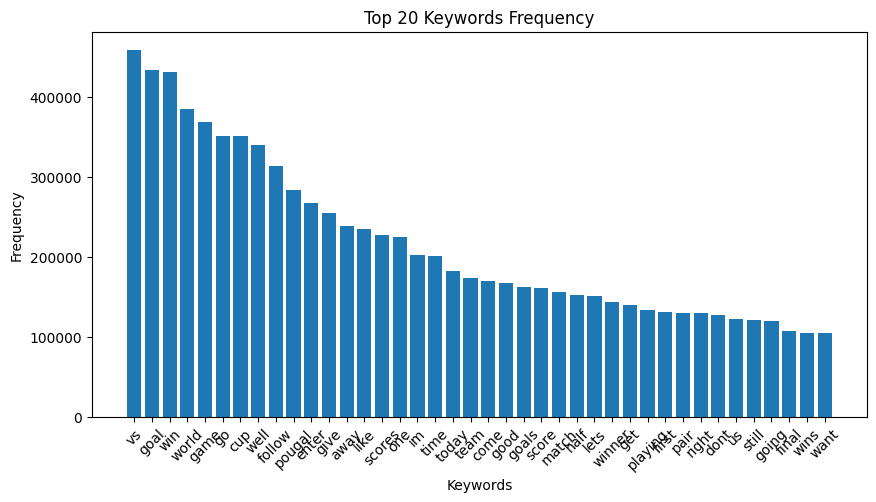

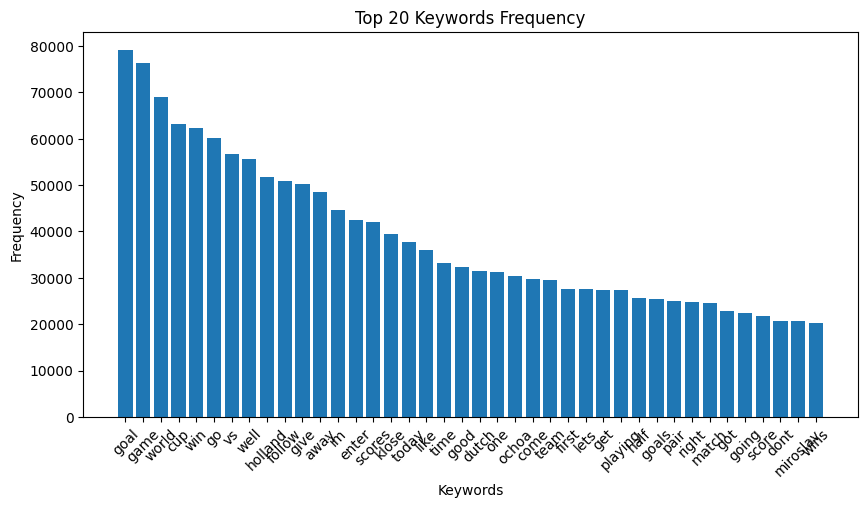

Proximity between keywords and keywords_eval: 79.60%
Vocabulary created in 16.89 seconds
--------------------------------------------------

Embedding...
Data embedded in 39.17 seconds
--------------------------------------------------

Creating the datasets...
Datasets created in 1.24 seconds
--------------------------------------------------

Training the model...
Epoch 1/15, Train Loss: 0.5989, Val Loss: 0.5621, Val Accuracy: 0.7006
Epoch 2/15, Train Loss: 0.5682, Val Loss: 0.5481, Val Accuracy: 0.7106
Epoch 3/15, Train Loss: 0.5555, Val Loss: 0.5406, Val Accuracy: 0.7144
Epoch 4/15, Train Loss: 0.5470, Val Loss: 0.5372, Val Accuracy: 0.7187
Epoch 5/15, Train Loss: 0.5403, Val Loss: 0.5332, Val Accuracy: 0.7197
Epoch 6/15, Train Loss: 0.5367, Val Loss: 0.5281, Val Accuracy: 0.7227
Epoch 7/15, Train Loss: 0.5319, Val Loss: 0.5280, Val Accuracy: 0.7237
Epoch 8/15, Train Loss: 0.5284, Val Loss: 0.5254, Val Accuracy: 0.7257
Epoch 9/15, Train Loss: 0.5259, Val Loss: 0.5225, Val Accuracy:

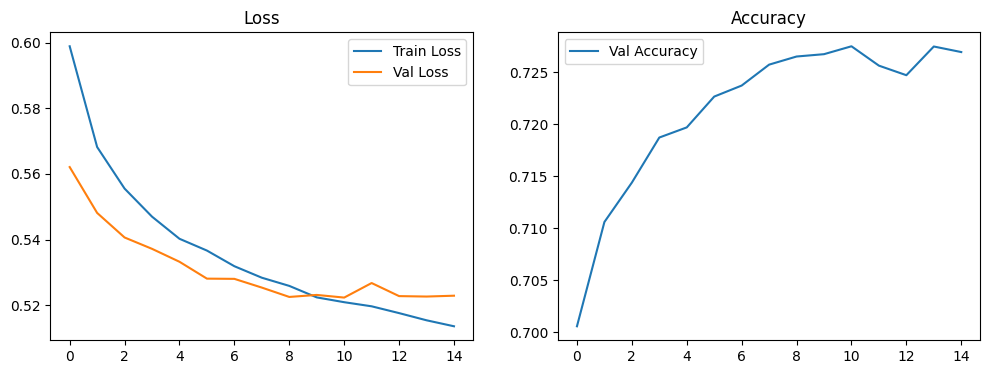

In [36]:
number_of_words_in_dict = 500

# Splitting
print("Splitting data...")
t = time()

train, test = train_test_split(df_train, test_size=0.3, random_state=42)

print(f"Data splitted in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Creating the vocabulary
print("Creating the vocabulary...")
t = time()

vocab, keywords = create_vocab(pd.concat([train, test, df_eval]), 'Tweet', tokenizer, number_of_words_in_dict)
vocab_eval, keywords_eval = create_vocab(df_eval, 'Tweet', tokenizer, number_of_words_in_dict)

plot_frequency(vocab, keywords)
plot_frequency(vocab_eval, keywords_eval)

print(f'Proximity between keywords and keywords_eval: {proximity_keywords(keywords, keywords_eval)*100:.2f}%')
print(f"Vocabulary created in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Embedding
print("Embedding...")
t = time()

train_X = embedding(train['Tweet'], keywords=keywords)
test_X = embedding(test['Tweet'], keywords=keywords)
eval_X = embedding(df_eval['Tweet'], keywords=keywords)

print(f"Data embedded in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Creating the datasets
print("Creating the datasets...")
t = time()

train_loader, test_loader = create_sets(train, test, train_X, test_X)

print(f"Datasets created in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Hyperparameters
input_dim = train_X.shape[1]
hidden_dims = [64, 32, 16]
dropouts = [0.3, 0.3, 0.3]
output_dim = 1

# Model
model = NNModel(input_dim, hidden_dims, output_dim, dropouts)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training
print("Training the model...")
t = time()

history = train_model(model, train_loader, test_loader, optimizer, criterion, device, num_epochs=15)

print(f"Model trained in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Plot training history
plot_history(history)


# Add stemming

In [53]:
stemmer = SnowballStemmer("english")

def preprocessing(df):
    # Compile regex patterns for efficiency
    url_pattern = re.compile(r"http[s]?://\S+|www\.\S+")
    mention_pattern = re.compile(r"@\w+")
    hashtag_pattern = re.compile(r"#\w+")
    number_pattern = re.compile(r"\d+")
    punctuation_pattern = re.compile(r"[^\w\s]")
    country_pattern = re.compile(r"\b(" + "|".join(map(re.escape, list_of_countries_trigrams)) + r")\b", re.IGNORECASE)
    rt_pattern = re.compile(r"rt")

    def clean_tweet(tweet):
        tweet = tweet.lower()  # Lowercase the text
        tweet = url_pattern.sub("", tweet)  # Remove URLs
        tweet = rt_pattern.sub("", tweet)  # Remove RT
        tweet = mention_pattern.sub("", tweet)  # Replace mentions with 'user'
        tweet = hashtag_pattern.sub("", tweet)  # Replace hashtags with 'hashtag'
        tweet = number_pattern.sub("", tweet)  # Replace numbers with 'number'
        tweet = country_pattern.sub("", tweet)  # Replace country trigrams with 'country'
        tweet = punctuation_pattern.sub("", tweet)  # Remove punctuation
        tweet = " ".join([word for word in tweet.split() if word not in stop_words])  # Remove stopwords
        words = tweet.split()
        words = [stemmer.stem(word) for word in words if word not in stop_words]  # Remove stopwords and apply stemming
        return " ".join(words)

    # Apply cleaning to the "Tweet" column
    df["Tweet"] = df["Tweet"].apply(clean_tweet)
    return df

--------------------------------------------------
Loading data...
Data loaded in 6.93 seconds
--------------------------------------------------

Grouping tweets...
Tweets grouped in 7.37 seconds
--------------------------------------------------

Preprocessing...
Data preprocessed in 747.56 seconds
--------------------------------------------------

Splitting data...
Data splitted in 0.07 seconds
--------------------------------------------------

Creating the vocabulary...


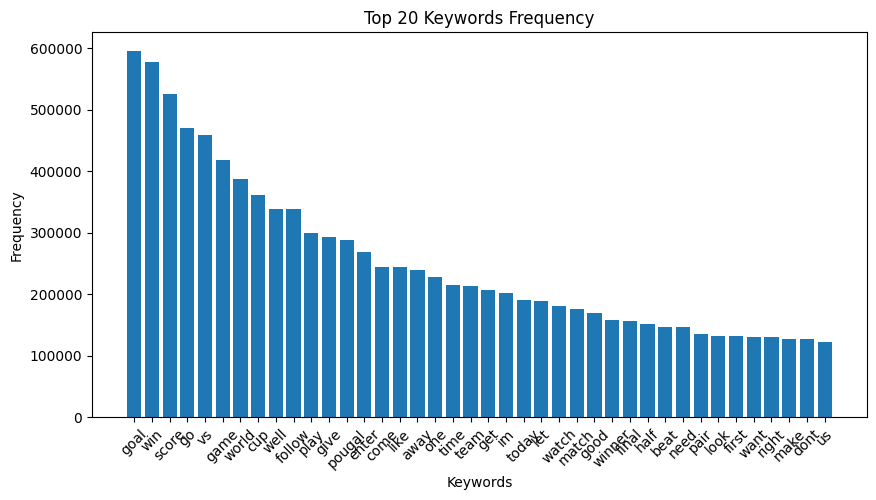

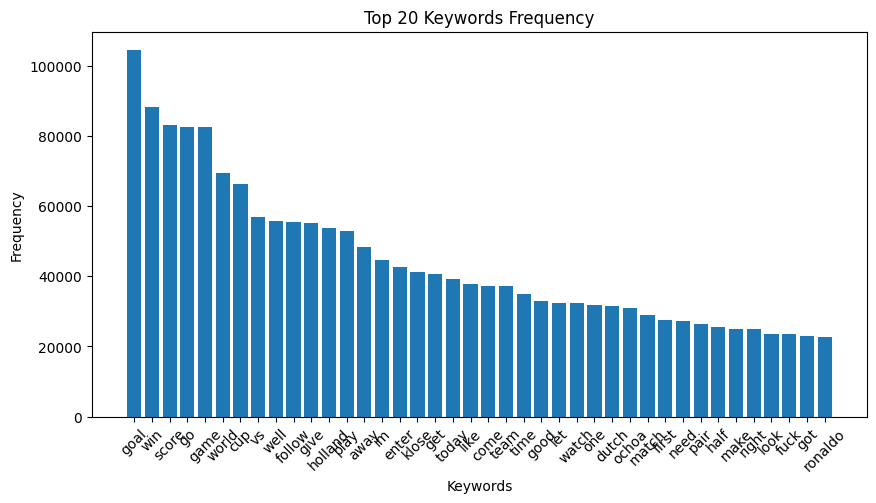

Proximity between keywords and keywords_eval: 81.60%
Vocabulary created in 16.76 seconds
--------------------------------------------------

Embedding...
Data embedded in 37.75 seconds
--------------------------------------------------

Creating the datasets...
Datasets created in 1.26 seconds
--------------------------------------------------

Training the model...
Epoch 1/15, Train Loss: 0.6005, Val Loss: 0.5634, Val Accuracy: 0.6955
Epoch 2/15, Train Loss: 0.5672, Val Loss: 0.5482, Val Accuracy: 0.7120
Epoch 3/15, Train Loss: 0.5543, Val Loss: 0.5397, Val Accuracy: 0.7166
Epoch 4/15, Train Loss: 0.5459, Val Loss: 0.5367, Val Accuracy: 0.7199
Epoch 5/15, Train Loss: 0.5396, Val Loss: 0.5296, Val Accuracy: 0.7226
Epoch 6/15, Train Loss: 0.5337, Val Loss: 0.5300, Val Accuracy: 0.7229
Epoch 7/15, Train Loss: 0.5290, Val Loss: 0.5291, Val Accuracy: 0.7241
Epoch 8/15, Train Loss: 0.5253, Val Loss: 0.5245, Val Accuracy: 0.7256
Epoch 9/15, Train Loss: 0.5226, Val Loss: 0.5251, Val Accuracy:

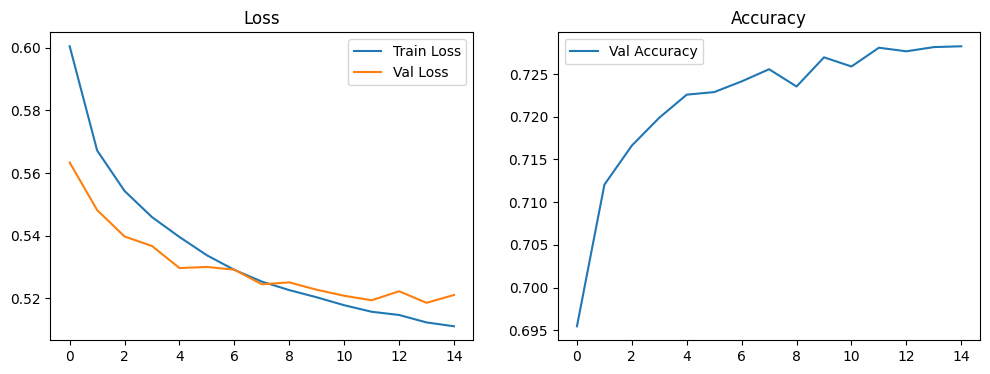

In [54]:
# Load data
print("-"*50)
print("Loading data...")
t = time()

df_train = load_data(path_to_training_tweets)
df_eval = load_data(path_to_eval_tweets)

print(f"Data loaded in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Grouping 
print("Grouping tweets...")
t = time()

df_train = concat_tweets(df_train, MAX_SUBGROUP=150)
df_eval = concat_tweets(df_eval, MAX_SUBGROUP=150, event_type=False)

print(f"Tweets grouped in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Preprocessing
print("Preprocessing...")
t = time()

df_train = preprocessing(df_train)
df_eval = preprocessing(df_eval)

print(f"Data preprocessed in {time()-t:.2f} seconds")
print("-"*50+"\n")

number_of_words_in_dict = 500

# Splitting
print("Splitting data...")
t = time()

train, test = train_test_split(df_train, test_size=0.3, random_state=42)

print(f"Data splitted in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Creating the vocabulary
print("Creating the vocabulary...")
t = time()

vocab, keywords = create_vocab(pd.concat([train, test, df_eval]), 'Tweet', tokenizer, number_of_words_in_dict)
vocab_eval, keywords_eval = create_vocab(df_eval, 'Tweet', tokenizer, number_of_words_in_dict)

plot_frequency(vocab, keywords)
plot_frequency(vocab_eval, keywords_eval)

print(f'Proximity between keywords and keywords_eval: {proximity_keywords(keywords, keywords_eval)*100:.2f}%')
print(f"Vocabulary created in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Embedding
print("Embedding...")
t = time()

train_X = embedding(train['Tweet'], keywords=keywords)
test_X = embedding(test['Tweet'], keywords=keywords)
eval_X = embedding(df_eval['Tweet'], keywords=keywords)

print(f"Data embedded in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Creating the datasets
print("Creating the datasets...")
t = time()

train_loader, test_loader = create_sets(train, test, train_X, test_X)

print(f"Datasets created in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Hyperparameters
input_dim = train_X.shape[1]
hidden_dims = [64, 32, 16]
dropouts = [0.3, 0.3, 0.3]
output_dim = 1

# Model
model = NNModel(input_dim, hidden_dims, output_dim, dropouts)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training
print("Training the model...")
t = time()

history = train_model(model, train_loader, test_loader, optimizer, criterion, device, num_epochs=15)

print(f"Model trained in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Plot training history
plot_history(history)


### With stemming but more words in the dictionnary

Splitting data...
Data splitted in 0.05 seconds
--------------------------------------------------

Creating the vocabulary...


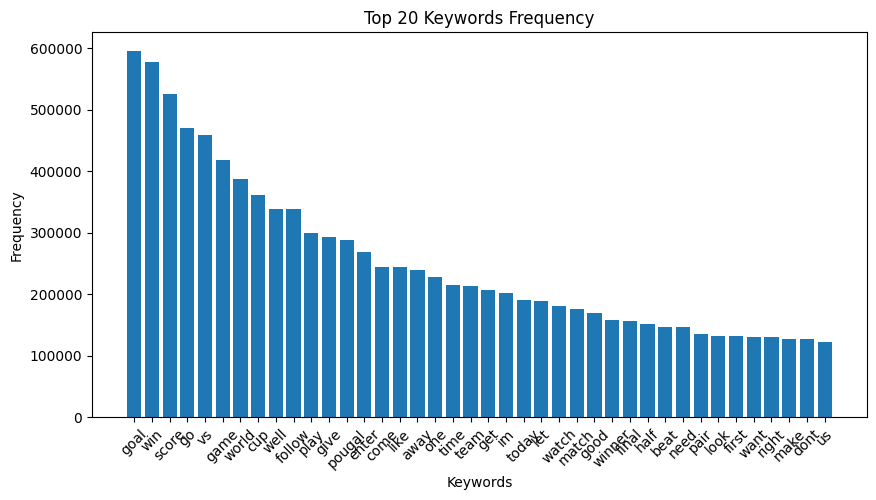

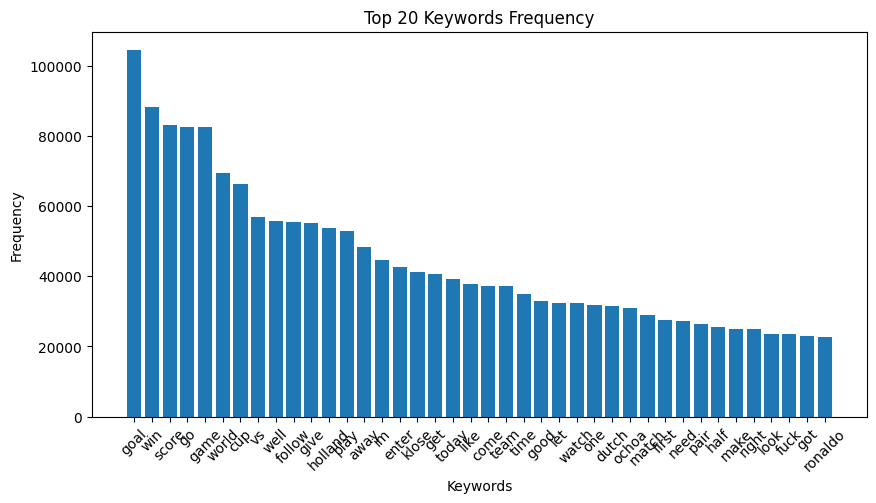

Proximity between keywords and keywords_eval: 78.72%
Vocabulary created in 16.69 seconds
--------------------------------------------------

Embedding...
Data embedded in 264.52 seconds
--------------------------------------------------

Creating the datasets...
Datasets created in 13.52 seconds
--------------------------------------------------

Training the model...
Epoch 1/15, Train Loss: 0.5775, Val Loss: 0.5395, Val Accuracy: 0.7146
Epoch 2/15, Train Loss: 0.5310, Val Loss: 0.5286, Val Accuracy: 0.7214
Epoch 3/15, Train Loss: 0.5056, Val Loss: 0.5199, Val Accuracy: 0.7279
Epoch 4/15, Train Loss: 0.4850, Val Loss: 0.5168, Val Accuracy: 0.7294
Epoch 5/15, Train Loss: 0.4670, Val Loss: 0.5177, Val Accuracy: 0.7313
Epoch 6/15, Train Loss: 0.4524, Val Loss: 0.5148, Val Accuracy: 0.7323
Epoch 7/15, Train Loss: 0.4403, Val Loss: 0.5172, Val Accuracy: 0.7329
Epoch 8/15, Train Loss: 0.4299, Val Loss: 0.5199, Val Accuracy: 0.7313
Epoch 9/15, Train Loss: 0.4183, Val Loss: 0.5178, Val Accurac

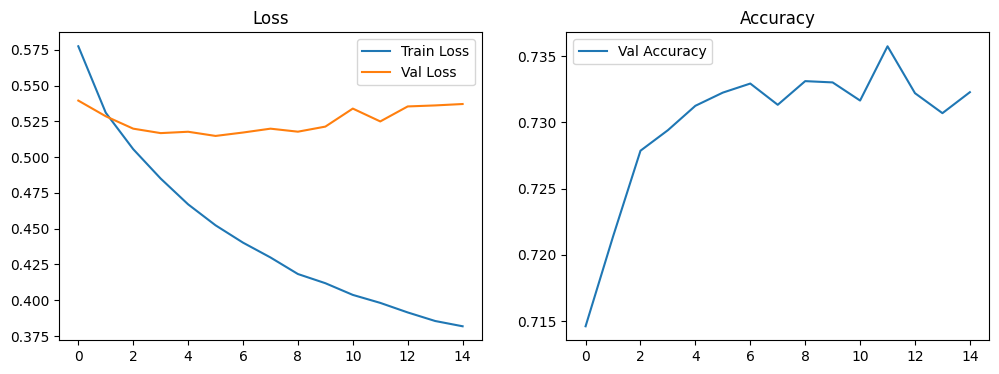

In [56]:
number_of_words_in_dict = 5000

# Splitting
print("Splitting data...")
t = time()

train, test = train_test_split(df_train, test_size=0.3, random_state=42)

print(f"Data splitted in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Creating the vocabulary
print("Creating the vocabulary...")
t = time()

vocab, keywords = create_vocab(pd.concat([train, test, df_eval]), 'Tweet', tokenizer, number_of_words_in_dict)
vocab_eval, keywords_eval = create_vocab(df_eval, 'Tweet', tokenizer, number_of_words_in_dict)

plot_frequency(vocab, keywords)
plot_frequency(vocab_eval, keywords_eval)

print(f'Proximity between keywords and keywords_eval: {proximity_keywords(keywords, keywords_eval)*100:.2f}%')
print(f"Vocabulary created in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Embedding
print("Embedding...")
t = time()

train_X = embedding(train['Tweet'], keywords=keywords)
test_X = embedding(test['Tweet'], keywords=keywords)
eval_X = embedding(df_eval['Tweet'], keywords=keywords)

print(f"Data embedded in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Creating the datasets
print("Creating the datasets...")
t = time()

train_loader, test_loader = create_sets(train, test, train_X, test_X)

print(f"Datasets created in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Hyperparameters
input_dim = train_X.shape[1]
hidden_dims = [64, 32, 16]
dropouts = [0.3, 0.3, 0.3]
output_dim = 1

# Model
model = NNModel(input_dim, hidden_dims, output_dim, dropouts)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training
print("Training the model...")
t = time()

history = train_model(model, train_loader, test_loader, optimizer, criterion, device, num_epochs=15)

print(f"Model trained in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Plot training history
plot_history(history)


Splitting data...
Data splitted in 0.09 seconds
--------------------------------------------------

Creating the vocabulary...


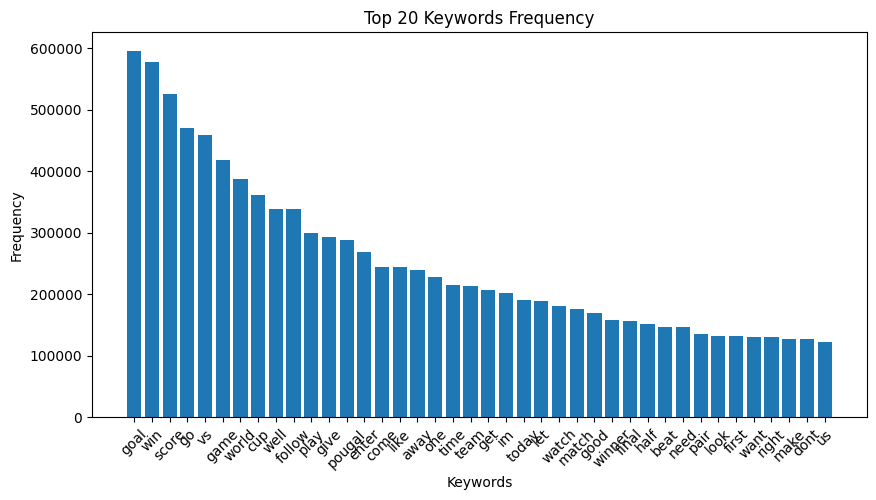

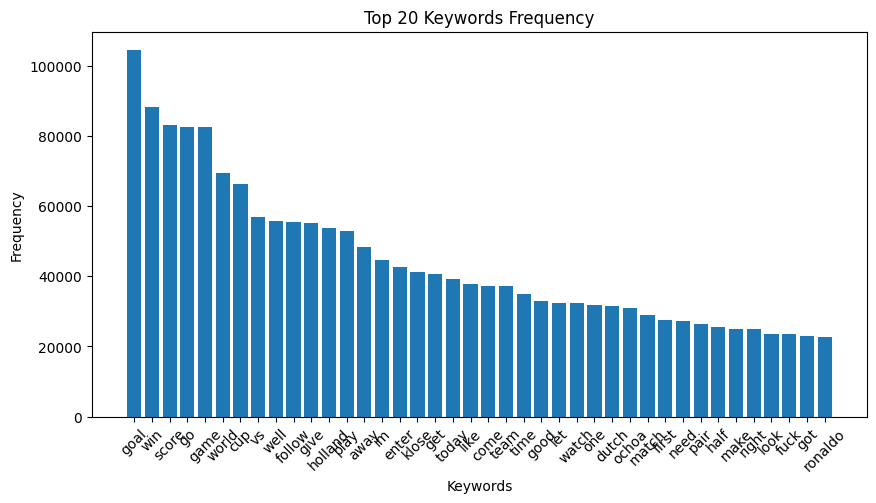

Proximity between keywords and keywords_eval: 79.90%
Vocabulary created in 16.63 seconds
--------------------------------------------------

Embedding...
Data embedded in 153.78 seconds
--------------------------------------------------

Creating the datasets...
Datasets created in 7.59 seconds
--------------------------------------------------

Training the model...
Epoch 1/15, Train Loss: 0.5763, Val Loss: 0.5406, Val Accuracy: 0.7145
Epoch 2/15, Train Loss: 0.5359, Val Loss: 0.5255, Val Accuracy: 0.7244
Epoch 3/15, Train Loss: 0.5147, Val Loss: 0.5179, Val Accuracy: 0.7283
Epoch 4/15, Train Loss: 0.4978, Val Loss: 0.5164, Val Accuracy: 0.7313
Epoch 5/15, Train Loss: 0.4833, Val Loss: 0.5125, Val Accuracy: 0.7338
Epoch 6/15, Train Loss: 0.4707, Val Loss: 0.5091, Val Accuracy: 0.7357
Epoch 7/15, Train Loss: 0.4609, Val Loss: 0.5076, Val Accuracy: 0.7374
Epoch 8/15, Train Loss: 0.4526, Val Loss: 0.5082, Val Accuracy: 0.7348
Epoch 9/15, Train Loss: 0.4453, Val Loss: 0.5096, Val Accuracy

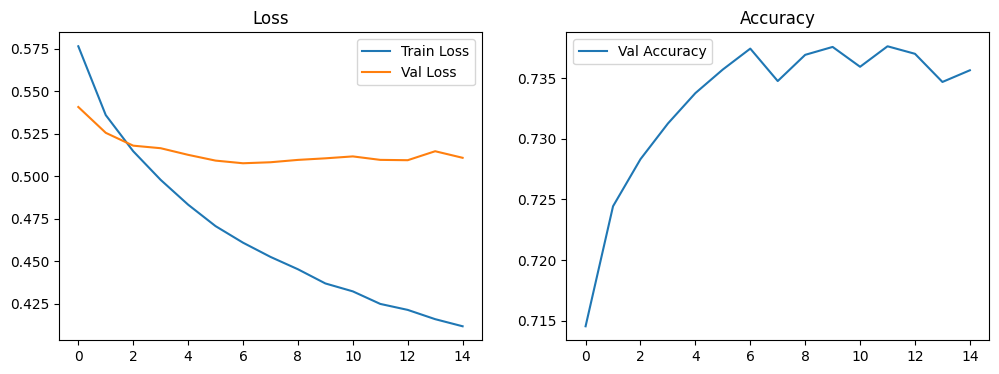

In [57]:
number_of_words_in_dict = 3000

# Splitting
print("Splitting data...")
t = time()

train, test = train_test_split(df_train, test_size=0.3, random_state=42)

print(f"Data splitted in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Creating the vocabulary
print("Creating the vocabulary...")
t = time()

vocab, keywords = create_vocab(pd.concat([train, test, df_eval]), 'Tweet', tokenizer, number_of_words_in_dict)
vocab_eval, keywords_eval = create_vocab(df_eval, 'Tweet', tokenizer, number_of_words_in_dict)

plot_frequency(vocab, keywords)
plot_frequency(vocab_eval, keywords_eval)

print(f'Proximity between keywords and keywords_eval: {proximity_keywords(keywords, keywords_eval)*100:.2f}%')
print(f"Vocabulary created in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Embedding
print("Embedding...")
t = time()

train_X = embedding(train['Tweet'], keywords=keywords)
test_X = embedding(test['Tweet'], keywords=keywords)
eval_X = embedding(df_eval['Tweet'], keywords=keywords)

print(f"Data embedded in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Creating the datasets
print("Creating the datasets...")
t = time()

train_loader, test_loader = create_sets(train, test, train_X, test_X)

print(f"Datasets created in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Hyperparameters
input_dim = train_X.shape[1]
hidden_dims = [64, 32, 16]
dropouts = [0.3, 0.3, 0.3]
output_dim = 1

# Model
model = NNModel(input_dim, hidden_dims, output_dim, dropouts)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training
print("Training the model...")
t = time()

history = train_model(model, train_loader, test_loader, optimizer, criterion, device, num_epochs=15)

print(f"Model trained in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Plot training history
plot_history(history)


Splitting data...
Data splitted in 0.04 seconds
--------------------------------------------------

Creating the vocabulary...


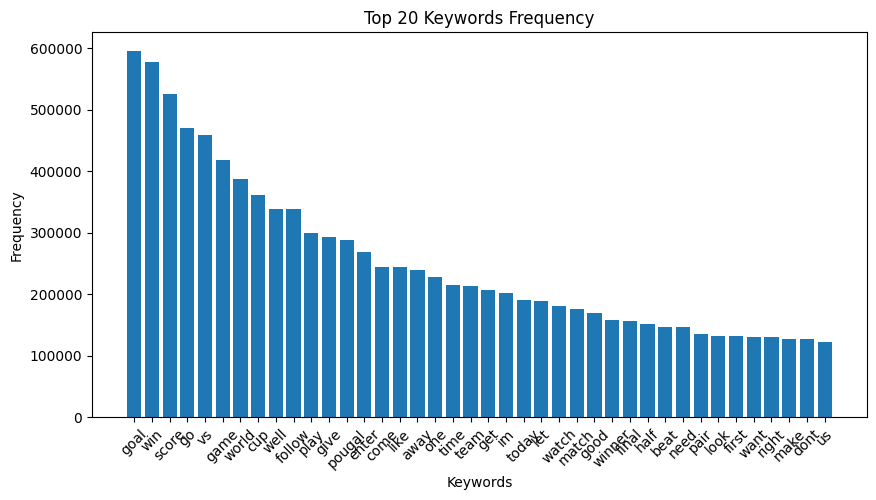

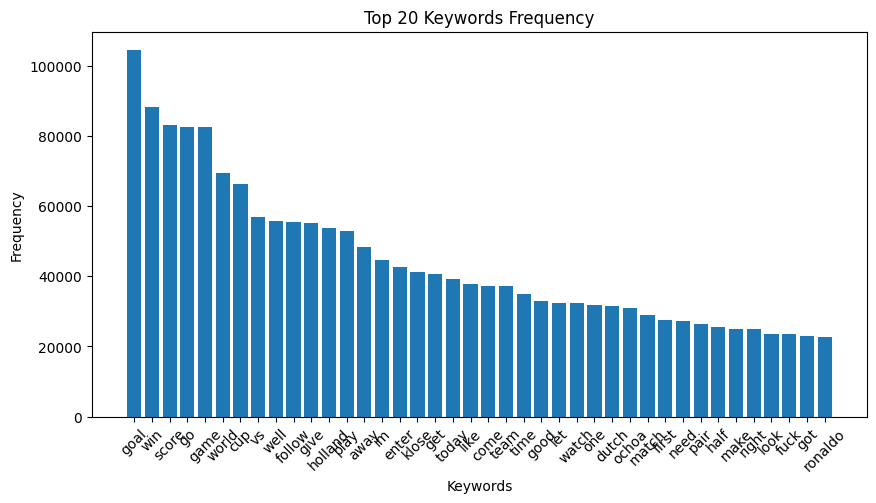

Proximity between keywords and keywords_eval: 81.40%
Vocabulary created in 16.91 seconds
--------------------------------------------------

Embedding...
Data embedded in 82.06 seconds
--------------------------------------------------

Creating the datasets...
Datasets created in 3.68 seconds
--------------------------------------------------

Training the model...
Epoch 1/15, Train Loss: 0.5833, Val Loss: 0.5493, Val Accuracy: 0.7104
Epoch 2/15, Train Loss: 0.5473, Val Loss: 0.5297, Val Accuracy: 0.7217
Epoch 3/15, Train Loss: 0.5289, Val Loss: 0.5212, Val Accuracy: 0.7259
Epoch 4/15, Train Loss: 0.5152, Val Loss: 0.5139, Val Accuracy: 0.7314
Epoch 5/15, Train Loss: 0.5038, Val Loss: 0.5118, Val Accuracy: 0.7339
Epoch 6/15, Train Loss: 0.4958, Val Loss: 0.5082, Val Accuracy: 0.7355
Epoch 7/15, Train Loss: 0.4877, Val Loss: 0.5058, Val Accuracy: 0.7383
Epoch 8/15, Train Loss: 0.4829, Val Loss: 0.5063, Val Accuracy: 0.7372
Epoch 9/15, Train Loss: 0.4772, Val Loss: 0.5051, Val Accuracy:

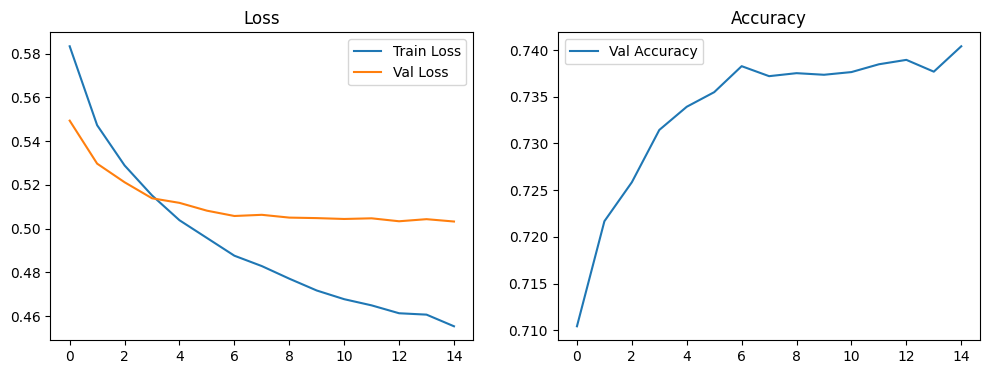

In [58]:
number_of_words_in_dict = 1500

# Splitting
print("Splitting data...")
t = time()

train, test = train_test_split(df_train, test_size=0.3, random_state=42)

print(f"Data splitted in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Creating the vocabulary
print("Creating the vocabulary...")
t = time()

vocab, keywords = create_vocab(pd.concat([train, test, df_eval]), 'Tweet', tokenizer, number_of_words_in_dict)
vocab_eval, keywords_eval = create_vocab(df_eval, 'Tweet', tokenizer, number_of_words_in_dict)

plot_frequency(vocab, keywords)
plot_frequency(vocab_eval, keywords_eval)

print(f'Proximity between keywords and keywords_eval: {proximity_keywords(keywords, keywords_eval)*100:.2f}%')
print(f"Vocabulary created in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Embedding
print("Embedding...")
t = time()

train_X = embedding(train['Tweet'], keywords=keywords)
test_X = embedding(test['Tweet'], keywords=keywords)
eval_X = embedding(df_eval['Tweet'], keywords=keywords)

print(f"Data embedded in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Creating the datasets
print("Creating the datasets...")
t = time()

train_loader, test_loader = create_sets(train, test, train_X, test_X)

print(f"Datasets created in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Hyperparameters
input_dim = train_X.shape[1]
hidden_dims = [64, 32, 16]
dropouts = [0.3, 0.3, 0.3]
output_dim = 1

# Model
model = NNModel(input_dim, hidden_dims, output_dim, dropouts)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training
print("Training the model...")
t = time()

history = train_model(model, train_loader, test_loader, optimizer, criterion, device, num_epochs=15)

print(f"Model trained in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Plot training history
plot_history(history)


In [ ]:
# Define hyperparameter ranges
hyperparams = {
    "hidden_dims": [[64], [128, 64], [256, 128, 64], [128, 64, 32, 16]],  # Layer sizes
    "dropouts": [[0.3, 0.3, 0.3, 0.3]],  # Dropout rates
    "learning_rate": [0.01, 0.001, 0.0005],  # Learning rates
    "weight_decay": [0, 1e-5, 1e-4],  # L2 regularization
}

# Create all combinations of hyperparameters
param_combinations = list(itertools.product(
    hyperparams["hidden_dims"],
    hyperparams["dropouts"],
    hyperparams["learning_rate"],
    hyperparams["weight_decay"]
))

# Chose 15 random combinations : 
param_combinations = random.sample(param_combinations, 15)

results = []  # To store results for each combination

for i, (hidden_dims, dropouts, learning_rate, weight_decay) in enumerate(param_combinations):
    print(f"Testing combination {i + 1}/{len(param_combinations)}:")
    print(f"Hidden Dims: {hidden_dims}, Dropouts: {dropouts}, Learning Rate: {learning_rate}, Weight Decay: {weight_decay}")
    
    # Ensure the length of hidden_dims matches dropouts
    if len(hidden_dims) != len(dropouts):
        dropouts = dropouts[:len(hidden_dims)]

    # Initialize model
    model = NNModel(input_dim, hidden_dims, output_dim, dropouts)
    model.to(device)

    # Initialize optimizer and criterion
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Train the model
    history = train_model(model, train_loader, test_loader, optimizer, criterion, device, num_epochs=15)

    # Evaluate on the test set (example metric: validation accuracy)
    val_accuracy = history["val_accuracy"][-1]
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    # Save results
    results.append({
        "hidden_dims": hidden_dims,
        "dropouts": dropouts,
        "learning_rate": learning_rate,
        "weight_decay": weight_decay,
        "val_accuracy": val_accuracy
    })

Testing combination 1/15:
Hidden Dims: [128, 64], Dropouts: [0.3, 0.3, 0.3, 0.3], Learning Rate: 0.001, Weight Decay: 0
Epoch 1/15, Train Loss: 0.5660, Val Loss: 0.5355, Val Accuracy: 0.7205
Epoch 2/15, Train Loss: 0.5262, Val Loss: 0.5208, Val Accuracy: 0.7322
Epoch 3/15, Train Loss: 0.5024, Val Loss: 0.5111, Val Accuracy: 0.7344
Epoch 4/15, Train Loss: 0.4844, Val Loss: 0.5049, Val Accuracy: 0.7377
Epoch 5/15, Train Loss: 0.4697, Val Loss: 0.5043, Val Accuracy: 0.7389
Epoch 6/15, Train Loss: 0.4557, Val Loss: 0.5086, Val Accuracy: 0.7371
Epoch 7/15, Train Loss: 0.4447, Val Loss: 0.5020, Val Accuracy: 0.7389
Epoch 8/15, Train Loss: 0.4354, Val Loss: 0.4995, Val Accuracy: 0.7423
Epoch 9/15, Train Loss: 0.4271, Val Loss: 0.5033, Val Accuracy: 0.7368
Epoch 10/15, Train Loss: 0.4187, Val Loss: 0.5055, Val Accuracy: 0.7399
Epoch 11/15, Train Loss: 0.4112, Val Loss: 0.5103, Val Accuracy: 0.7360
Epoch 12/15, Train Loss: 0.4045, Val Loss: 0.5047, Val Accuracy: 0.7382
Epoch 13/15, Train Loss: 

In [67]:
# Sort results by validation accuracy
results_sorted = sorted(results, key=lambda x: x["val_accuracy"], reverse=True)

# Print the top configurations
print("Top Configurations:")
for result in results_sorted:
    print(result)

Top Configurations:
{'hidden_dims': [128, 64, 32, 16], 'dropouts': [0.3, 0.3, 0.3, 0.3], 'learning_rate': 0.001, 'weight_decay': 1e-05, 'val_accuracy': 0.7426214070158166}
{'hidden_dims': [128, 64], 'dropouts': [0.3, 0.3], 'learning_rate': 0.0005, 'weight_decay': 0.0001, 'val_accuracy': 0.7421612482075209}
{'hidden_dims': [256, 128, 64], 'dropouts': [0.3, 0.3, 0.3], 'learning_rate': 0.001, 'weight_decay': 0, 'val_accuracy': 0.7414977634141643}
{'hidden_dims': [128, 64, 32, 16], 'dropouts': [0.3, 0.3, 0.3, 0.3], 'learning_rate': 0.0005, 'weight_decay': 1e-05, 'val_accuracy': 0.741016201870599}
{'hidden_dims': [256, 128, 64], 'dropouts': [0.3, 0.3, 0.3], 'learning_rate': 0.0005, 'weight_decay': 0, 'val_accuracy': 0.7406844594739208}
{'hidden_dims': [128, 64, 32, 16], 'dropouts': [0.3, 0.3, 0.3, 0.3], 'learning_rate': 0.01, 'weight_decay': 0, 'val_accuracy': 0.7405453416946686}
{'hidden_dims': [128, 64], 'dropouts': [0.3, 0.3], 'learning_rate': 0.01, 'weight_decay': 0, 'val_accuracy': 0.7

In [84]:
# Define models and their hyperparameter ranges
models = {
    "RandomForest": {
        "model": RandomForestClassifier,
        "hyperparams": {
            "n_estimators": [50, 100, 200],
            "max_depth": [10, 20],
            "min_samples_split": [2, 5, 10],
        }
    },
    "XGBoost": {
        "model": XGBClassifier,
        "hyperparams": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 6, 10],
        }
    },
}

# Generate random combinations for each model
random_combinations = {}
for model_name, model_data in models.items():
    hyperparams = model_data["hyperparams"]
    param_combinations = list(itertools.product(*hyperparams.values()))
    random_combinations[model_name] = random.sample(param_combinations, 2)  # Randomly sample 5 combinations

results = []

for model_name, combinations in random_combinations.items():
    for i, params in enumerate(combinations):
        print(f"Testing {model_name} combination {i + 1}/{len(combinations)}:")
        
        # Unpack parameters
        param_names = list(models[model_name]["hyperparams"].keys())
        param_dict = dict(zip(param_names, params))

        print(param_dict)
        
        # Initialize model
        model = models[model_name]["model"](**param_dict)
        
        # Train-test split (use your preprocessed `train_X` and `train_y`)
        train_X_split, val_X_split, train_y_split, val_y_split = embedding(train['Tweet'], keywords=keywords), embedding(test['Tweet'], keywords=keywords), train['EventType'], test['EventType']
        
        # Train the model
        model.fit(train_X_split, train_y_split)
        
        # Evaluate on the validation set
        val_preds = model.predict(val_X_split)
        val_accuracy = accuracy_score(val_y_split, val_preds)
        
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        
        # Save results
        results.append({
            "model": model_name,
            "params": param_dict,
            "val_accuracy": val_accuracy
        })

Testing RandomForest combination 1/2:
{'n_estimators': 50, 'max_depth': 20, 'min_samples_split': 5}
Validation Accuracy: 0.6986
Testing RandomForest combination 2/2:
{'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 2}
Validation Accuracy: 0.7031
Testing XGBoost combination 1/2:
{'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 10}
Validation Accuracy: 0.6870
Testing XGBoost combination 2/2:
{'n_estimators': 50, 'learning_rate': 0.1, 'max_depth': 10}
Validation Accuracy: 0.7148
Testing SVM combination 1/2:
{'C': 0.1, 'kernel': 'linear', 'gamma': 'auto'}


: 

: 